In [1]:
import sys
import numpy as np
import keras
from keras.utils import Sequence
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

Using TensorFlow backend.


In [2]:
BATCH_SIZE = 32
SEED = 777
SHAPE = (512, 512, 4)
DIR = 'C:\kaggle'
VAL_RATIO = 0.1 # 10 % as validation
THRESHOLD = 0.5 # due to different cost of True Positive vs False Positive, this is the probability threshold to predict the class as 'yes'

ia.seed(SEED)

In [3]:
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = pd.read_csv(DIR + '/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)


In [4]:
# credits: https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
# credits: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, shuffle = False, use_cache = False, augment = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.augment = augment
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], shape[2]), dtype=np.float16)
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]
                
        if self.augment == True:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Strengthen or weaken the contrast in each image.
                    iaa.ContrastNormalization((0.75, 1.5)),
                    # Add gaussian noise.
                    # For 50% of all images, we sample the noise once per pixel.
                    # For the other 50% of all images, we sample the noise per pixel AND
                    # channel. This can change the color (not only brightness) of the
                    # pixels.
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])], random_order=True)

            X = np.concatenate((X, seq.augment_images(X), seq.augment_images(X), seq.augment_images(X)), 0)
            y = np.concatenate((y, y, y, y), 0)
        
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        R = Image.open(path + '_red.png')
        G = Image.open(path + '_green.png')
        B = Image.open(path + '_blue.png')
        Y = Image.open(path + '_yellow.png')

        im = np.stack((
            np.array(R), 
            np.array(G), 
            np.array(B),
            np.array(Y)), -1)
        
        im = cv2.resize(im, (SHAPE[0], SHAPE[1]))
        im = np.divide(im, 255)
        return im

# Using in Keras
Let's try to test the multi_processing.

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, ReLU, LeakyReLU, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import metrics
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import keras
import tensorflow as tf

from tensorflow import set_random_seed
set_random_seed(SEED)

In [6]:
# credits: https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras

def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [7]:
# some basic useless model
def create_model(input_shape):
    
    dropRate = 0.25
    
    init = Input(input_shape)
    x = BatchNormalization(axis=-1)(init)
    x = Conv2D(32, (3, 3))(x) #, strides=(2,2))(x)
    x = ReLU()(x)

    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    ginp1 = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(ginp1)
    x = Conv2D(64, (3, 3), strides=(2,2))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(64, (3, 3))(x)
    x = ReLU()(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    ginp2 = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(ginp2)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(128, (3, 3))(x)
    x = ReLU()(x)
    ginp3 = Dropout(dropRate)(x)
    
    gap1 = GlobalAveragePooling2D()(ginp1)
    gap2 = GlobalAveragePooling2D()(ginp2)
    gap3 = GlobalAveragePooling2D()(ginp3)
    
    x = Concatenate()([gap1, gap2, gap3])
    
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropRate)(x)
    
    x = BatchNormalization(axis=-1)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    x = Dense(28)(x)
    x = Activation('sigmoid')(x)
    
    model = Model(init, x)
    
    return model

In [8]:
model = create_model(SHAPE)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(1e-03),
    metrics=['acc',f1])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 4)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 512, 512, 4)  16          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 510, 510, 32) 1184        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 510, 510, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 28)           7196        dropout_5[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28)           0           dense_3[0][0]                    
Total params: 597,388
Trainable params: 595,268
Non-trainable params: 2,120
__________________________________________________________________________________________________


In [9]:
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

pathsTrain = paths[0:lastTrainIndex]
labelsTrain = labels[0:lastTrainIndex]
pathsVal = paths[lastTrainIndex:]
labelsVal = labels[lastTrainIndex:]

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)

tg = ProteinDataGenerator(pathsTrain, labelsTrain, BATCH_SIZE, SHAPE, use_cache=False, augment = False, shuffle = False)
vg = ProteinDataGenerator(pathsVal, labelsVal, BATCH_SIZE, SHAPE, use_cache=False, shuffle = False)

# https://keras.io/callbacks/#modelcheckpoint
checkpoint = ModelCheckpoint('./base.model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min', period=1)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min')

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (3108, 28)


In [10]:
epochs = 20

use_multiprocessing = False # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 
workers = 1 # DO NOT COMBINE MULTIPROCESSING WITH CACHE! 

hist = model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=epochs,
    use_multiprocessing=use_multiprocessing,
    workers=workers,
    verbose=1,
    callbacks=[checkpoint])

Epoch 1/20


151/874 [====>.........................] - ETA: 2:23:37 - loss: 0.8130 - acc: 0.4710 - f1: 0.092 - ETA: 1:17:16 - loss: 0.7801 - acc: 0.5100 - f1: 0.088 - ETA: 54:57 - loss: 0.7601 - acc: 0.5327 - f1: 0.0850  - ETA: 43:41 - loss: 0.7303 - acc: 0.5605 - f1: 0.083 - ETA: 36:55 - loss: 0.7033 - acc: 0.5879 - f1: 0.083 - ETA: 32:31 - loss: 0.6757 - acc: 0.6161 - f1: 0.082 - ETA: 29:22 - loss: 0.6493 - acc: 0.6421 - f1: 0.082 - ETA: 26:57 - loss: 0.6261 - acc: 0.6653 - f1: 0.082 - ETA: 25:15 - loss: 0.6040 - acc: 0.6827 - f1: 0.082 - ETA: 24:47 - loss: 0.5821 - acc: 0.7006 - f1: 0.081 - ETA: 24:41 - loss: 0.5616 - acc: 0.7173 - f1: 0.081 - ETA: 24:08 - loss: 0.5409 - acc: 0.7341 - f1: 0.080 - ETA: 23:40 - loss: 0.5225 - acc: 0.7481 - f1: 0.081 - ETA: 23:15 - loss: 0.5048 - acc: 0.7614 - f1: 0.079 - ETA: 22:52 - loss: 0.4893 - acc: 0.7725 - f1: 0.078 - ETA: 22:34 - loss: 0.4733 - acc: 0.7832 - f1: 0.077 - ETA: 22:18 - loss: 0.4595 - acc: 0.7925 - f1: 0.076 - ETA: 21:56 - loss: 0.4466 - acc: 

302/874 [=========>....................] - ETA: 16:16 - loss: 0.2127 - acc: 0.9264 - f1: 0.067 - ETA: 16:16 - loss: 0.2122 - acc: 0.9267 - f1: 0.067 - ETA: 16:15 - loss: 0.2122 - acc: 0.9267 - f1: 0.067 - ETA: 16:14 - loss: 0.2119 - acc: 0.9269 - f1: 0.067 - ETA: 16:13 - loss: 0.2115 - acc: 0.9271 - f1: 0.067 - ETA: 16:12 - loss: 0.2112 - acc: 0.9272 - f1: 0.067 - ETA: 16:11 - loss: 0.2108 - acc: 0.9273 - f1: 0.067 - ETA: 16:10 - loss: 0.2106 - acc: 0.9274 - f1: 0.067 - ETA: 16:09 - loss: 0.2105 - acc: 0.9275 - f1: 0.067 - ETA: 16:10 - loss: 0.2100 - acc: 0.9277 - f1: 0.067 - ETA: 16:10 - loss: 0.2099 - acc: 0.9278 - f1: 0.067 - ETA: 16:09 - loss: 0.2097 - acc: 0.9279 - f1: 0.067 - ETA: 16:09 - loss: 0.2095 - acc: 0.9280 - f1: 0.067 - ETA: 16:08 - loss: 0.2093 - acc: 0.9281 - f1: 0.067 - ETA: 16:08 - loss: 0.2092 - acc: 0.9282 - f1: 0.067 - ETA: 16:07 - loss: 0.2090 - acc: 0.9283 - f1: 0.067 - ETA: 16:06 - loss: 0.2089 - acc: 0.9284 - f1: 0.067 - ETA: 16:05 - loss: 0.2088 - acc: 0.9284

454/874 [==============>...............] - ETA: 13:11 - loss: 0.1902 - acc: 0.9362 - f1: 0.072 - ETA: 13:10 - loss: 0.1901 - acc: 0.9362 - f1: 0.072 - ETA: 13:08 - loss: 0.1899 - acc: 0.9363 - f1: 0.072 - ETA: 13:07 - loss: 0.1899 - acc: 0.9363 - f1: 0.072 - ETA: 13:05 - loss: 0.1898 - acc: 0.9363 - f1: 0.072 - ETA: 13:04 - loss: 0.1897 - acc: 0.9364 - f1: 0.072 - ETA: 13:02 - loss: 0.1897 - acc: 0.9364 - f1: 0.072 - ETA: 13:01 - loss: 0.1897 - acc: 0.9364 - f1: 0.072 - ETA: 12:59 - loss: 0.1896 - acc: 0.9364 - f1: 0.072 - ETA: 12:58 - loss: 0.1895 - acc: 0.9365 - f1: 0.072 - ETA: 12:57 - loss: 0.1895 - acc: 0.9365 - f1: 0.072 - ETA: 12:55 - loss: 0.1895 - acc: 0.9365 - f1: 0.072 - ETA: 12:56 - loss: 0.1894 - acc: 0.9365 - f1: 0.072 - ETA: 12:54 - loss: 0.1894 - acc: 0.9366 - f1: 0.072 - ETA: 12:53 - loss: 0.1892 - acc: 0.9366 - f1: 0.072 - ETA: 12:52 - loss: 0.1891 - acc: 0.9367 - f1: 0.072 - ETA: 12:50 - loss: 0.1891 - acc: 0.9367 - f1: 0.072 - ETA: 12:49 - loss: 0.1890 - acc: 0.9367

611/874 [===================>..........] - ETA: 9:35 - loss: 0.1815 - acc: 0.9396 - f1: 0.07 - ETA: 9:34 - loss: 0.1815 - acc: 0.9396 - f1: 0.07 - ETA: 9:33 - loss: 0.1815 - acc: 0.9397 - f1: 0.07 - ETA: 9:31 - loss: 0.1814 - acc: 0.9397 - f1: 0.07 - ETA: 9:30 - loss: 0.1814 - acc: 0.9397 - f1: 0.07 - ETA: 9:28 - loss: 0.1813 - acc: 0.9397 - f1: 0.07 - ETA: 9:27 - loss: 0.1813 - acc: 0.9398 - f1: 0.07 - ETA: 9:26 - loss: 0.1813 - acc: 0.9398 - f1: 0.07 - ETA: 9:24 - loss: 0.1813 - acc: 0.9398 - f1: 0.07 - ETA: 9:22 - loss: 0.1812 - acc: 0.9398 - f1: 0.07 - ETA: 9:21 - loss: 0.1812 - acc: 0.9398 - f1: 0.07 - ETA: 9:20 - loss: 0.1811 - acc: 0.9398 - f1: 0.07 - ETA: 9:18 - loss: 0.1811 - acc: 0.9398 - f1: 0.07 - ETA: 9:17 - loss: 0.1810 - acc: 0.9399 - f1: 0.07 - ETA: 9:16 - loss: 0.1809 - acc: 0.9399 - f1: 0.07 - ETA: 9:14 - loss: 0.1809 - acc: 0.9399 - f1: 0.07 - ETA: 9:13 - loss: 0.1809 - acc: 0.9399 - f1: 0.07 - ETA: 9:11 - loss: 0.1808 - acc: 0.9399 - f1: 0.07 - ETA: 9:10 - loss: 0.1

768/874 [=========================>....] - ETA: 5:59 - loss: 0.1762 - acc: 0.9415 - f1: 0.07 - ETA: 5:57 - loss: 0.1762 - acc: 0.9415 - f1: 0.07 - ETA: 5:56 - loss: 0.1761 - acc: 0.9415 - f1: 0.07 - ETA: 5:54 - loss: 0.1761 - acc: 0.9415 - f1: 0.07 - ETA: 5:53 - loss: 0.1761 - acc: 0.9416 - f1: 0.07 - ETA: 5:52 - loss: 0.1761 - acc: 0.9416 - f1: 0.07 - ETA: 5:50 - loss: 0.1760 - acc: 0.9416 - f1: 0.07 - ETA: 5:49 - loss: 0.1760 - acc: 0.9416 - f1: 0.07 - ETA: 5:47 - loss: 0.1760 - acc: 0.9416 - f1: 0.07 - ETA: 5:46 - loss: 0.1760 - acc: 0.9416 - f1: 0.07 - ETA: 5:45 - loss: 0.1760 - acc: 0.9416 - f1: 0.07 - ETA: 5:43 - loss: 0.1760 - acc: 0.9416 - f1: 0.07 - ETA: 5:42 - loss: 0.1759 - acc: 0.9416 - f1: 0.07 - ETA: 5:41 - loss: 0.1759 - acc: 0.9416 - f1: 0.07 - ETA: 5:39 - loss: 0.1759 - acc: 0.9416 - f1: 0.07 - ETA: 5:38 - loss: 0.1759 - acc: 0.9416 - f1: 0.07 - ETA: 5:36 - loss: 0.1758 - acc: 0.9416 - f1: 0.07 - ETA: 5:35 - loss: 0.1758 - acc: 0.9416 - f1: 0.07 - ETA: 5:34 - loss: 0.1

874/874 [==============================] - ETA: 2:23 - loss: 0.1731 - acc: 0.9426 - f1: 0.07 - ETA: 2:22 - loss: 0.1730 - acc: 0.9426 - f1: 0.07 - ETA: 2:20 - loss: 0.1730 - acc: 0.9426 - f1: 0.07 - ETA: 2:19 - loss: 0.1730 - acc: 0.9426 - f1: 0.07 - ETA: 2:17 - loss: 0.1730 - acc: 0.9426 - f1: 0.07 - ETA: 2:16 - loss: 0.1730 - acc: 0.9426 - f1: 0.07 - ETA: 2:15 - loss: 0.1729 - acc: 0.9426 - f1: 0.07 - ETA: 2:13 - loss: 0.1729 - acc: 0.9426 - f1: 0.07 - ETA: 2:12 - loss: 0.1729 - acc: 0.9426 - f1: 0.07 - ETA: 2:11 - loss: 0.1729 - acc: 0.9426 - f1: 0.07 - ETA: 2:09 - loss: 0.1729 - acc: 0.9426 - f1: 0.07 - ETA: 2:08 - loss: 0.1728 - acc: 0.9427 - f1: 0.07 - ETA: 2:06 - loss: 0.1728 - acc: 0.9427 - f1: 0.07 - ETA: 2:05 - loss: 0.1727 - acc: 0.9427 - f1: 0.07 - ETA: 2:04 - loss: 0.1727 - acc: 0.9426 - f1: 0.07 - ETA: 2:02 - loss: 0.1727 - acc: 0.9427 - f1: 0.07 - ETA: 2:01 - loss: 0.1727 - acc: 0.9427 - f1: 0.07 - ETA: 2:00 - loss: 0.1727 - acc: 0.9427 - f1: 0.07 - ETA: 1:58 - loss: 0.1

151/874 [====>.........................] - ETA: 10:26 - loss: 0.1385 - acc: 0.9531 - f1: 0.103 - ETA: 10:18 - loss: 0.1459 - acc: 0.9509 - f1: 0.095 - ETA: 10:10 - loss: 0.1602 - acc: 0.9483 - f1: 0.097 - ETA: 10:13 - loss: 0.1634 - acc: 0.9459 - f1: 0.097 - ETA: 10:16 - loss: 0.1593 - acc: 0.9475 - f1: 0.096 - ETA: 10:16 - loss: 0.1580 - acc: 0.9472 - f1: 0.095 - ETA: 10:14 - loss: 0.1567 - acc: 0.9471 - f1: 0.094 - ETA: 10:13 - loss: 0.1606 - acc: 0.9463 - f1: 0.092 - ETA: 10:11 - loss: 0.1602 - acc: 0.9462 - f1: 0.093 - ETA: 10:11 - loss: 0.1593 - acc: 0.9464 - f1: 0.094 - ETA: 10:13 - loss: 0.1606 - acc: 0.9464 - f1: 0.093 - ETA: 10:11 - loss: 0.1604 - acc: 0.9463 - f1: 0.093 - ETA: 10:09 - loss: 0.1604 - acc: 0.9466 - f1: 0.092 - ETA: 10:08 - loss: 0.1595 - acc: 0.9467 - f1: 0.091 - ETA: 10:07 - loss: 0.1604 - acc: 0.9465 - f1: 0.091 - ETA: 10:07 - loss: 0.1603 - acc: 0.9467 - f1: 0.091 - ETA: 10:08 - loss: 0.1604 - acc: 0.9472 - f1: 0.091 - ETA: 10:06 - loss: 0.1609 - acc: 0.9471

302/874 [=========>....................] - ETA: 14:37 - loss: 0.1554 - acc: 0.9480 - f1: 0.094 - ETA: 14:35 - loss: 0.1554 - acc: 0.9479 - f1: 0.093 - ETA: 14:34 - loss: 0.1552 - acc: 0.9480 - f1: 0.094 - ETA: 14:33 - loss: 0.1552 - acc: 0.9480 - f1: 0.094 - ETA: 14:31 - loss: 0.1552 - acc: 0.9479 - f1: 0.093 - ETA: 14:31 - loss: 0.1552 - acc: 0.9479 - f1: 0.094 - ETA: 14:30 - loss: 0.1552 - acc: 0.9479 - f1: 0.094 - ETA: 14:30 - loss: 0.1551 - acc: 0.9479 - f1: 0.094 - ETA: 14:29 - loss: 0.1551 - acc: 0.9479 - f1: 0.094 - ETA: 14:28 - loss: 0.1551 - acc: 0.9478 - f1: 0.094 - ETA: 14:27 - loss: 0.1550 - acc: 0.9479 - f1: 0.094 - ETA: 14:27 - loss: 0.1550 - acc: 0.9479 - f1: 0.094 - ETA: 14:27 - loss: 0.1550 - acc: 0.9479 - f1: 0.094 - ETA: 14:25 - loss: 0.1550 - acc: 0.9479 - f1: 0.094 - ETA: 14:24 - loss: 0.1550 - acc: 0.9479 - f1: 0.094 - ETA: 14:22 - loss: 0.1550 - acc: 0.9480 - f1: 0.094 - ETA: 14:22 - loss: 0.1549 - acc: 0.9480 - f1: 0.094 - ETA: 14:21 - loss: 0.1550 - acc: 0.9480

455/874 [==============>...............] - ETA: 12:02 - loss: 0.1532 - acc: 0.9485 - f1: 0.096 - ETA: 12:01 - loss: 0.1531 - acc: 0.9486 - f1: 0.096 - ETA: 11:59 - loss: 0.1530 - acc: 0.9485 - f1: 0.096 - ETA: 11:58 - loss: 0.1530 - acc: 0.9485 - f1: 0.096 - ETA: 11:57 - loss: 0.1529 - acc: 0.9486 - f1: 0.096 - ETA: 11:56 - loss: 0.1530 - acc: 0.9486 - f1: 0.096 - ETA: 11:55 - loss: 0.1529 - acc: 0.9486 - f1: 0.096 - ETA: 11:54 - loss: 0.1529 - acc: 0.9486 - f1: 0.096 - ETA: 11:53 - loss: 0.1528 - acc: 0.9486 - f1: 0.097 - ETA: 11:51 - loss: 0.1529 - acc: 0.9486 - f1: 0.096 - ETA: 11:51 - loss: 0.1529 - acc: 0.9486 - f1: 0.097 - ETA: 11:49 - loss: 0.1529 - acc: 0.9486 - f1: 0.097 - ETA: 11:48 - loss: 0.1528 - acc: 0.9486 - f1: 0.097 - ETA: 11:47 - loss: 0.1529 - acc: 0.9486 - f1: 0.097 - ETA: 11:46 - loss: 0.1529 - acc: 0.9486 - f1: 0.097 - ETA: 11:45 - loss: 0.1530 - acc: 0.9486 - f1: 0.097 - ETA: 11:44 - loss: 0.1530 - acc: 0.9485 - f1: 0.097 - ETA: 11:43 - loss: 0.1530 - acc: 0.9486

612/874 [====================>.........] - ETA: 9:02 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 9:01 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 9:00 - loss: 0.1511 - acc: 0.9489 - f1: 0.10 - ETA: 8:58 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:57 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:56 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:55 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:53 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:52 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:51 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:50 - loss: 0.1510 - acc: 0.9490 - f1: 0.10 - ETA: 8:48 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:47 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:46 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:44 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:43 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:42 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:41 - loss: 0.1510 - acc: 0.9489 - f1: 0.10 - ETA: 8:40 - loss: 0.1

769/874 [=========================>....] - ETA: 5:44 - loss: 0.1493 - acc: 0.9495 - f1: 0.10 - ETA: 5:42 - loss: 0.1493 - acc: 0.9495 - f1: 0.10 - ETA: 5:41 - loss: 0.1493 - acc: 0.9495 - f1: 0.10 - ETA: 5:40 - loss: 0.1493 - acc: 0.9495 - f1: 0.10 - ETA: 5:38 - loss: 0.1493 - acc: 0.9495 - f1: 0.10 - ETA: 5:37 - loss: 0.1493 - acc: 0.9495 - f1: 0.10 - ETA: 5:36 - loss: 0.1492 - acc: 0.9495 - f1: 0.10 - ETA: 5:35 - loss: 0.1492 - acc: 0.9495 - f1: 0.10 - ETA: 5:33 - loss: 0.1492 - acc: 0.9494 - f1: 0.10 - ETA: 5:32 - loss: 0.1492 - acc: 0.9495 - f1: 0.10 - ETA: 5:31 - loss: 0.1492 - acc: 0.9494 - f1: 0.10 - ETA: 5:30 - loss: 0.1492 - acc: 0.9494 - f1: 0.10 - ETA: 5:28 - loss: 0.1492 - acc: 0.9494 - f1: 0.10 - ETA: 5:27 - loss: 0.1492 - acc: 0.9494 - f1: 0.10 - ETA: 5:26 - loss: 0.1492 - acc: 0.9495 - f1: 0.10 - ETA: 5:24 - loss: 0.1492 - acc: 0.9495 - f1: 0.10 - ETA: 5:23 - loss: 0.1492 - acc: 0.9495 - f1: 0.10 - ETA: 5:22 - loss: 0.1491 - acc: 0.9495 - f1: 0.10 - ETA: 5:21 - loss: 0.1

874/874 [==============================] - ETA: 2:18 - loss: 0.1479 - acc: 0.9498 - f1: 0.10 - ETA: 2:16 - loss: 0.1479 - acc: 0.9498 - f1: 0.10 - ETA: 2:15 - loss: 0.1479 - acc: 0.9498 - f1: 0.10 - ETA: 2:14 - loss: 0.1479 - acc: 0.9498 - f1: 0.10 - ETA: 2:12 - loss: 0.1479 - acc: 0.9498 - f1: 0.10 - ETA: 2:11 - loss: 0.1479 - acc: 0.9498 - f1: 0.10 - ETA: 2:10 - loss: 0.1478 - acc: 0.9498 - f1: 0.10 - ETA: 2:08 - loss: 0.1478 - acc: 0.9498 - f1: 0.10 - ETA: 2:07 - loss: 0.1478 - acc: 0.9498 - f1: 0.10 - ETA: 2:06 - loss: 0.1477 - acc: 0.9498 - f1: 0.10 - ETA: 2:04 - loss: 0.1477 - acc: 0.9498 - f1: 0.10 - ETA: 2:03 - loss: 0.1477 - acc: 0.9498 - f1: 0.10 - ETA: 2:02 - loss: 0.1477 - acc: 0.9498 - f1: 0.10 - ETA: 2:00 - loss: 0.1477 - acc: 0.9498 - f1: 0.10 - ETA: 1:59 - loss: 0.1477 - acc: 0.9498 - f1: 0.10 - ETA: 1:58 - loss: 0.1477 - acc: 0.9498 - f1: 0.10 - ETA: 1:56 - loss: 0.1477 - acc: 0.9498 - f1: 0.10 - ETA: 1:55 - loss: 0.1476 - acc: 0.9498 - f1: 0.10 - ETA: 1:54 - loss: 0.1

151/874 [====>.........................] - ETA: 10:12 - loss: 0.1339 - acc: 0.9576 - f1: 0.141 - ETA: 10:11 - loss: 0.1360 - acc: 0.9542 - f1: 0.147 - ETA: 10:15 - loss: 0.1410 - acc: 0.9535 - f1: 0.138 - ETA: 10:15 - loss: 0.1393 - acc: 0.9545 - f1: 0.145 - ETA: 10:18 - loss: 0.1393 - acc: 0.9536 - f1: 0.148 - ETA: 10:20 - loss: 0.1405 - acc: 0.9535 - f1: 0.149 - ETA: 10:17 - loss: 0.1417 - acc: 0.9526 - f1: 0.145 - ETA: 10:17 - loss: 0.1401 - acc: 0.9516 - f1: 0.142 - ETA: 10:14 - loss: 0.1385 - acc: 0.9521 - f1: 0.142 - ETA: 10:14 - loss: 0.1378 - acc: 0.9521 - f1: 0.140 - ETA: 10:17 - loss: 0.1382 - acc: 0.9520 - f1: 0.138 - ETA: 10:16 - loss: 0.1392 - acc: 0.9522 - f1: 0.138 - ETA: 10:16 - loss: 0.1399 - acc: 0.9515 - f1: 0.137 - ETA: 10:15 - loss: 0.1380 - acc: 0.9519 - f1: 0.136 - ETA: 10:14 - loss: 0.1375 - acc: 0.9523 - f1: 0.136 - ETA: 10:14 - loss: 0.1368 - acc: 0.9524 - f1: 0.136 - ETA: 10:17 - loss: 0.1387 - acc: 0.9519 - f1: 0.135 - ETA: 10:18 - loss: 0.1392 - acc: 0.9515

302/874 [=========>....................] - ETA: 14:42 - loss: 0.1384 - acc: 0.9523 - f1: 0.128 - ETA: 14:40 - loss: 0.1383 - acc: 0.9523 - f1: 0.128 - ETA: 14:39 - loss: 0.1382 - acc: 0.9523 - f1: 0.129 - ETA: 14:37 - loss: 0.1382 - acc: 0.9524 - f1: 0.129 - ETA: 14:36 - loss: 0.1384 - acc: 0.9524 - f1: 0.128 - ETA: 14:35 - loss: 0.1384 - acc: 0.9524 - f1: 0.129 - ETA: 14:34 - loss: 0.1385 - acc: 0.9523 - f1: 0.129 - ETA: 14:33 - loss: 0.1384 - acc: 0.9524 - f1: 0.129 - ETA: 14:32 - loss: 0.1383 - acc: 0.9524 - f1: 0.129 - ETA: 14:31 - loss: 0.1383 - acc: 0.9524 - f1: 0.129 - ETA: 14:30 - loss: 0.1384 - acc: 0.9524 - f1: 0.129 - ETA: 14:29 - loss: 0.1385 - acc: 0.9523 - f1: 0.129 - ETA: 14:28 - loss: 0.1386 - acc: 0.9523 - f1: 0.129 - ETA: 14:27 - loss: 0.1387 - acc: 0.9523 - f1: 0.129 - ETA: 14:26 - loss: 0.1386 - acc: 0.9523 - f1: 0.129 - ETA: 14:25 - loss: 0.1386 - acc: 0.9523 - f1: 0.129 - ETA: 14:25 - loss: 0.1385 - acc: 0.9523 - f1: 0.129 - ETA: 14:23 - loss: 0.1385 - acc: 0.9523

455/874 [==============>...............] - ETA: 11:59 - loss: 0.1373 - acc: 0.9522 - f1: 0.132 - ETA: 11:58 - loss: 0.1374 - acc: 0.9522 - f1: 0.132 - ETA: 11:57 - loss: 0.1373 - acc: 0.9522 - f1: 0.132 - ETA: 11:56 - loss: 0.1373 - acc: 0.9522 - f1: 0.132 - ETA: 11:55 - loss: 0.1373 - acc: 0.9522 - f1: 0.132 - ETA: 11:54 - loss: 0.1373 - acc: 0.9522 - f1: 0.132 - ETA: 11:52 - loss: 0.1373 - acc: 0.9522 - f1: 0.132 - ETA: 11:51 - loss: 0.1372 - acc: 0.9522 - f1: 0.132 - ETA: 11:50 - loss: 0.1372 - acc: 0.9522 - f1: 0.132 - ETA: 11:49 - loss: 0.1372 - acc: 0.9522 - f1: 0.132 - ETA: 11:48 - loss: 0.1371 - acc: 0.9522 - f1: 0.132 - ETA: 11:47 - loss: 0.1372 - acc: 0.9522 - f1: 0.132 - ETA: 11:46 - loss: 0.1372 - acc: 0.9522 - f1: 0.132 - ETA: 11:45 - loss: 0.1372 - acc: 0.9522 - f1: 0.132 - ETA: 11:44 - loss: 0.1372 - acc: 0.9522 - f1: 0.132 - ETA: 11:43 - loss: 0.1372 - acc: 0.9522 - f1: 0.132 - ETA: 11:41 - loss: 0.1372 - acc: 0.9522 - f1: 0.132 - ETA: 11:41 - loss: 0.1372 - acc: 0.9522

612/874 [====================>.........] - ETA: 8:57 - loss: 0.1354 - acc: 0.9525 - f1: 0.13 - ETA: 8:56 - loss: 0.1353 - acc: 0.9526 - f1: 0.13 - ETA: 8:55 - loss: 0.1354 - acc: 0.9525 - f1: 0.13 - ETA: 8:54 - loss: 0.1353 - acc: 0.9525 - f1: 0.13 - ETA: 8:52 - loss: 0.1354 - acc: 0.9525 - f1: 0.13 - ETA: 8:51 - loss: 0.1354 - acc: 0.9525 - f1: 0.13 - ETA: 8:50 - loss: 0.1353 - acc: 0.9526 - f1: 0.13 - ETA: 8:49 - loss: 0.1353 - acc: 0.9526 - f1: 0.13 - ETA: 8:47 - loss: 0.1353 - acc: 0.9526 - f1: 0.13 - ETA: 8:46 - loss: 0.1354 - acc: 0.9526 - f1: 0.13 - ETA: 8:45 - loss: 0.1354 - acc: 0.9526 - f1: 0.13 - ETA: 8:44 - loss: 0.1354 - acc: 0.9526 - f1: 0.13 - ETA: 8:42 - loss: 0.1353 - acc: 0.9526 - f1: 0.13 - ETA: 8:41 - loss: 0.1353 - acc: 0.9526 - f1: 0.13 - ETA: 8:40 - loss: 0.1353 - acc: 0.9526 - f1: 0.13 - ETA: 8:39 - loss: 0.1353 - acc: 0.9526 - f1: 0.13 - ETA: 8:38 - loss: 0.1354 - acc: 0.9526 - f1: 0.13 - ETA: 8:36 - loss: 0.1353 - acc: 0.9526 - f1: 0.13 - ETA: 8:35 - loss: 0.1

769/874 [=========================>....] - ETA: 5:40 - loss: 0.1347 - acc: 0.9529 - f1: 0.13 - ETA: 5:39 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:38 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:36 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:35 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:34 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:33 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:31 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:30 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:29 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:28 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:26 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:25 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:24 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:22 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:21 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:20 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:18 - loss: 0.1346 - acc: 0.9529 - f1: 0.13 - ETA: 5:17 - loss: 0.1

874/874 [==============================] - ETA: 2:17 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 2:15 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 2:14 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 2:13 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 2:11 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 2:10 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 2:09 - loss: 0.1334 - acc: 0.9533 - f1: 0.14 - ETA: 2:07 - loss: 0.1333 - acc: 0.9533 - f1: 0.14 - ETA: 2:06 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 2:05 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 2:03 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 2:02 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 2:01 - loss: 0.1333 - acc: 0.9533 - f1: 0.14 - ETA: 2:00 - loss: 0.1333 - acc: 0.9533 - f1: 0.14 - ETA: 1:58 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 1:57 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 1:56 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 1:54 - loss: 0.1333 - acc: 0.9534 - f1: 0.14 - ETA: 1:53 - loss: 0.1

151/874 [====>.........................] - ETA: 10:22 - loss: 0.1318 - acc: 0.9498 - f1: 0.169 - ETA: 10:30 - loss: 0.1218 - acc: 0.9520 - f1: 0.161 - ETA: 10:20 - loss: 0.1263 - acc: 0.9524 - f1: 0.159 - ETA: 10:17 - loss: 0.1230 - acc: 0.9528 - f1: 0.168 - ETA: 10:12 - loss: 0.1280 - acc: 0.9525 - f1: 0.160 - ETA: 10:12 - loss: 0.1245 - acc: 0.9539 - f1: 0.163 - ETA: 10:15 - loss: 0.1260 - acc: 0.9539 - f1: 0.164 - ETA: 10:14 - loss: 0.1272 - acc: 0.9542 - f1: 0.160 - ETA: 10:09 - loss: 0.1317 - acc: 0.9532 - f1: 0.155 - ETA: 10:10 - loss: 0.1279 - acc: 0.9546 - f1: 0.154 - ETA: 10:09 - loss: 0.1276 - acc: 0.9549 - f1: 0.158 - ETA: 10:11 - loss: 0.1277 - acc: 0.9547 - f1: 0.157 - ETA: 10:12 - loss: 0.1289 - acc: 0.9549 - f1: 0.156 - ETA: 10:13 - loss: 0.1283 - acc: 0.9549 - f1: 0.159 - ETA: 10:19 - loss: 0.1270 - acc: 0.9553 - f1: 0.159 - ETA: 10:20 - loss: 0.1259 - acc: 0.9556 - f1: 0.161 - ETA: 10:21 - loss: 0.1268 - acc: 0.9553 - f1: 0.162 - ETA: 11:08 - loss: 0.1271 - acc: 0.9553

302/874 [=========>....................] - ETA: 14:36 - loss: 0.1257 - acc: 0.9559 - f1: 0.170 - ETA: 14:35 - loss: 0.1257 - acc: 0.9559 - f1: 0.170 - ETA: 14:34 - loss: 0.1256 - acc: 0.9559 - f1: 0.170 - ETA: 14:33 - loss: 0.1254 - acc: 0.9560 - f1: 0.170 - ETA: 14:32 - loss: 0.1252 - acc: 0.9561 - f1: 0.170 - ETA: 14:32 - loss: 0.1252 - acc: 0.9560 - f1: 0.170 - ETA: 14:30 - loss: 0.1251 - acc: 0.9560 - f1: 0.170 - ETA: 14:29 - loss: 0.1252 - acc: 0.9560 - f1: 0.170 - ETA: 14:28 - loss: 0.1250 - acc: 0.9560 - f1: 0.171 - ETA: 14:27 - loss: 0.1250 - acc: 0.9560 - f1: 0.171 - ETA: 14:26 - loss: 0.1249 - acc: 0.9561 - f1: 0.170 - ETA: 14:25 - loss: 0.1249 - acc: 0.9560 - f1: 0.170 - ETA: 14:24 - loss: 0.1248 - acc: 0.9561 - f1: 0.170 - ETA: 14:23 - loss: 0.1248 - acc: 0.9561 - f1: 0.171 - ETA: 14:23 - loss: 0.1247 - acc: 0.9561 - f1: 0.171 - ETA: 14:22 - loss: 0.1248 - acc: 0.9561 - f1: 0.170 - ETA: 14:21 - loss: 0.1246 - acc: 0.9562 - f1: 0.171 - ETA: 14:20 - loss: 0.1246 - acc: 0.9562

455/874 [==============>...............] - ETA: 11:57 - loss: 0.1225 - acc: 0.9569 - f1: 0.175 - ETA: 11:56 - loss: 0.1225 - acc: 0.9569 - f1: 0.175 - ETA: 11:55 - loss: 0.1225 - acc: 0.9569 - f1: 0.175 - ETA: 11:54 - loss: 0.1225 - acc: 0.9569 - f1: 0.175 - ETA: 11:53 - loss: 0.1224 - acc: 0.9570 - f1: 0.175 - ETA: 11:52 - loss: 0.1224 - acc: 0.9570 - f1: 0.175 - ETA: 11:50 - loss: 0.1224 - acc: 0.9570 - f1: 0.175 - ETA: 11:49 - loss: 0.1223 - acc: 0.9570 - f1: 0.176 - ETA: 11:48 - loss: 0.1223 - acc: 0.9570 - f1: 0.176 - ETA: 11:47 - loss: 0.1223 - acc: 0.9570 - f1: 0.176 - ETA: 11:46 - loss: 0.1223 - acc: 0.9570 - f1: 0.176 - ETA: 11:45 - loss: 0.1222 - acc: 0.9570 - f1: 0.176 - ETA: 11:44 - loss: 0.1222 - acc: 0.9570 - f1: 0.176 - ETA: 11:43 - loss: 0.1221 - acc: 0.9570 - f1: 0.176 - ETA: 11:42 - loss: 0.1220 - acc: 0.9571 - f1: 0.176 - ETA: 11:40 - loss: 0.1220 - acc: 0.9570 - f1: 0.176 - ETA: 11:39 - loss: 0.1220 - acc: 0.9570 - f1: 0.176 - ETA: 11:38 - loss: 0.1220 - acc: 0.9571

612/874 [====================>.........] - ETA: 8:58 - loss: 0.1204 - acc: 0.9574 - f1: 0.18 - ETA: 8:56 - loss: 0.1205 - acc: 0.9574 - f1: 0.18 - ETA: 8:55 - loss: 0.1204 - acc: 0.9574 - f1: 0.18 - ETA: 8:54 - loss: 0.1204 - acc: 0.9574 - f1: 0.18 - ETA: 8:53 - loss: 0.1204 - acc: 0.9574 - f1: 0.18 - ETA: 8:51 - loss: 0.1204 - acc: 0.9575 - f1: 0.18 - ETA: 8:50 - loss: 0.1203 - acc: 0.9575 - f1: 0.18 - ETA: 8:49 - loss: 0.1203 - acc: 0.9575 - f1: 0.18 - ETA: 8:48 - loss: 0.1202 - acc: 0.9575 - f1: 0.18 - ETA: 8:47 - loss: 0.1202 - acc: 0.9575 - f1: 0.18 - ETA: 8:45 - loss: 0.1202 - acc: 0.9575 - f1: 0.18 - ETA: 8:44 - loss: 0.1202 - acc: 0.9575 - f1: 0.18 - ETA: 8:43 - loss: 0.1201 - acc: 0.9575 - f1: 0.18 - ETA: 8:42 - loss: 0.1201 - acc: 0.9575 - f1: 0.18 - ETA: 8:40 - loss: 0.1201 - acc: 0.9575 - f1: 0.18 - ETA: 8:39 - loss: 0.1202 - acc: 0.9575 - f1: 0.18 - ETA: 8:38 - loss: 0.1202 - acc: 0.9575 - f1: 0.18 - ETA: 8:37 - loss: 0.1202 - acc: 0.9575 - f1: 0.18 - ETA: 8:35 - loss: 0.1

769/874 [=========================>....] - ETA: 5:40 - loss: 0.1197 - acc: 0.9577 - f1: 0.18 - ETA: 5:39 - loss: 0.1197 - acc: 0.9577 - f1: 0.18 - ETA: 5:38 - loss: 0.1197 - acc: 0.9577 - f1: 0.18 - ETA: 5:37 - loss: 0.1197 - acc: 0.9577 - f1: 0.18 - ETA: 5:35 - loss: 0.1197 - acc: 0.9577 - f1: 0.18 - ETA: 5:34 - loss: 0.1197 - acc: 0.9577 - f1: 0.18 - ETA: 5:33 - loss: 0.1197 - acc: 0.9578 - f1: 0.18 - ETA: 5:31 - loss: 0.1196 - acc: 0.9578 - f1: 0.18 - ETA: 5:30 - loss: 0.1197 - acc: 0.9578 - f1: 0.18 - ETA: 5:29 - loss: 0.1197 - acc: 0.9578 - f1: 0.18 - ETA: 5:28 - loss: 0.1197 - acc: 0.9578 - f1: 0.18 - ETA: 5:26 - loss: 0.1197 - acc: 0.9578 - f1: 0.18 - ETA: 5:25 - loss: 0.1197 - acc: 0.9578 - f1: 0.18 - ETA: 5:24 - loss: 0.1197 - acc: 0.9578 - f1: 0.18 - ETA: 5:22 - loss: 0.1197 - acc: 0.9578 - f1: 0.18 - ETA: 5:21 - loss: 0.1197 - acc: 0.9578 - f1: 0.18 - ETA: 5:20 - loss: 0.1196 - acc: 0.9578 - f1: 0.18 - ETA: 5:19 - loss: 0.1196 - acc: 0.9578 - f1: 0.18 - ETA: 5:17 - loss: 0.1

874/874 [==============================] - ETA: 2:17 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 2:15 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 2:14 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 2:13 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 2:11 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 2:10 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 2:09 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 2:07 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 2:06 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 2:05 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 2:03 - loss: 0.1189 - acc: 0.9580 - f1: 0.18 - ETA: 2:02 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 2:01 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 2:00 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 1:58 - loss: 0.1190 - acc: 0.9580 - f1: 0.18 - ETA: 1:57 - loss: 0.1189 - acc: 0.9580 - f1: 0.18 - ETA: 1:56 - loss: 0.1189 - acc: 0.9580 - f1: 0.18 - ETA: 1:54 - loss: 0.1189 - acc: 0.9580 - f1: 0.18 - ETA: 1:53 - loss: 0.1

151/874 [====>.........................] - ETA: 10:20 - loss: 0.1033 - acc: 0.9643 - f1: 0.238 - ETA: 10:19 - loss: 0.1046 - acc: 0.9604 - f1: 0.202 - ETA: 10:17 - loss: 0.1085 - acc: 0.9598 - f1: 0.218 - ETA: 10:15 - loss: 0.1195 - acc: 0.9565 - f1: 0.211 - ETA: 10:14 - loss: 0.1147 - acc: 0.9583 - f1: 0.207 - ETA: 10:14 - loss: 0.1115 - acc: 0.9598 - f1: 0.207 - ETA: 10:13 - loss: 0.1142 - acc: 0.9585 - f1: 0.209 - ETA: 10:12 - loss: 0.1172 - acc: 0.9569 - f1: 0.204 - ETA: 10:15 - loss: 0.1154 - acc: 0.9576 - f1: 0.203 - ETA: 10:13 - loss: 0.1152 - acc: 0.9571 - f1: 0.203 - ETA: 10:16 - loss: 0.1149 - acc: 0.9572 - f1: 0.198 - ETA: 10:16 - loss: 0.1163 - acc: 0.9568 - f1: 0.198 - ETA: 10:17 - loss: 0.1155 - acc: 0.9571 - f1: 0.201 - ETA: 10:18 - loss: 0.1159 - acc: 0.9573 - f1: 0.201 - ETA: 10:20 - loss: 0.1157 - acc: 0.9572 - f1: 0.202 - ETA: 10:18 - loss: 0.1148 - acc: 0.9576 - f1: 0.204 - ETA: 10:17 - loss: 0.1138 - acc: 0.9580 - f1: 0.204 - ETA: 10:27 - loss: 0.1141 - acc: 0.9577

302/874 [=========>....................] - ETA: 14:46 - loss: 0.1109 - acc: 0.9604 - f1: 0.211 - ETA: 14:44 - loss: 0.1109 - acc: 0.9603 - f1: 0.211 - ETA: 14:43 - loss: 0.1110 - acc: 0.9603 - f1: 0.211 - ETA: 14:42 - loss: 0.1109 - acc: 0.9603 - f1: 0.211 - ETA: 14:40 - loss: 0.1108 - acc: 0.9604 - f1: 0.211 - ETA: 14:39 - loss: 0.1109 - acc: 0.9603 - f1: 0.211 - ETA: 14:39 - loss: 0.1109 - acc: 0.9603 - f1: 0.211 - ETA: 14:38 - loss: 0.1110 - acc: 0.9603 - f1: 0.211 - ETA: 14:37 - loss: 0.1112 - acc: 0.9602 - f1: 0.211 - ETA: 14:36 - loss: 0.1111 - acc: 0.9603 - f1: 0.211 - ETA: 14:35 - loss: 0.1113 - acc: 0.9602 - f1: 0.211 - ETA: 14:33 - loss: 0.1113 - acc: 0.9602 - f1: 0.211 - ETA: 14:32 - loss: 0.1113 - acc: 0.9602 - f1: 0.211 - ETA: 14:32 - loss: 0.1114 - acc: 0.9602 - f1: 0.211 - ETA: 14:31 - loss: 0.1113 - acc: 0.9602 - f1: 0.211 - ETA: 14:30 - loss: 0.1113 - acc: 0.9602 - f1: 0.211 - ETA: 14:28 - loss: 0.1114 - acc: 0.9602 - f1: 0.211 - ETA: 14:27 - loss: 0.1115 - acc: 0.9601

455/874 [==============>...............] - ETA: 12:00 - loss: 0.1110 - acc: 0.9603 - f1: 0.211 - ETA: 11:58 - loss: 0.1109 - acc: 0.9603 - f1: 0.211 - ETA: 11:57 - loss: 0.1109 - acc: 0.9603 - f1: 0.211 - ETA: 11:56 - loss: 0.1109 - acc: 0.9603 - f1: 0.211 - ETA: 11:55 - loss: 0.1109 - acc: 0.9603 - f1: 0.211 - ETA: 11:54 - loss: 0.1110 - acc: 0.9603 - f1: 0.211 - ETA: 11:53 - loss: 0.1111 - acc: 0.9603 - f1: 0.211 - ETA: 11:51 - loss: 0.1111 - acc: 0.9603 - f1: 0.211 - ETA: 11:50 - loss: 0.1111 - acc: 0.9603 - f1: 0.211 - ETA: 11:49 - loss: 0.1111 - acc: 0.9603 - f1: 0.211 - ETA: 11:48 - loss: 0.1111 - acc: 0.9603 - f1: 0.211 - ETA: 11:47 - loss: 0.1112 - acc: 0.9602 - f1: 0.211 - ETA: 11:46 - loss: 0.1112 - acc: 0.9602 - f1: 0.211 - ETA: 11:45 - loss: 0.1113 - acc: 0.9602 - f1: 0.211 - ETA: 11:44 - loss: 0.1113 - acc: 0.9602 - f1: 0.211 - ETA: 11:42 - loss: 0.1113 - acc: 0.9602 - f1: 0.211 - ETA: 11:41 - loss: 0.1112 - acc: 0.9602 - f1: 0.211 - ETA: 11:39 - loss: 0.1112 - acc: 0.9602

612/874 [====================>.........] - ETA: 8:57 - loss: 0.1106 - acc: 0.9603 - f1: 0.21 - ETA: 8:56 - loss: 0.1106 - acc: 0.9603 - f1: 0.21 - ETA: 8:55 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:54 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:52 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:51 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:50 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:49 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:48 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:46 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:45 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:44 - loss: 0.1107 - acc: 0.9604 - f1: 0.21 - ETA: 8:42 - loss: 0.1107 - acc: 0.9604 - f1: 0.21 - ETA: 8:41 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:40 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:39 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:37 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:36 - loss: 0.1106 - acc: 0.9604 - f1: 0.21 - ETA: 8:35 - loss: 0.1

769/874 [=========================>....] - ETA: 5:40 - loss: 0.1105 - acc: 0.9606 - f1: 0.21 - ETA: 5:38 - loss: 0.1105 - acc: 0.9606 - f1: 0.21 - ETA: 5:37 - loss: 0.1105 - acc: 0.9606 - f1: 0.21 - ETA: 5:36 - loss: 0.1105 - acc: 0.9606 - f1: 0.21 - ETA: 5:35 - loss: 0.1105 - acc: 0.9606 - f1: 0.21 - ETA: 5:33 - loss: 0.1104 - acc: 0.9606 - f1: 0.21 - ETA: 5:32 - loss: 0.1104 - acc: 0.9606 - f1: 0.21 - ETA: 5:31 - loss: 0.1104 - acc: 0.9606 - f1: 0.21 - ETA: 5:29 - loss: 0.1104 - acc: 0.9606 - f1: 0.21 - ETA: 5:28 - loss: 0.1104 - acc: 0.9606 - f1: 0.21 - ETA: 5:27 - loss: 0.1103 - acc: 0.9606 - f1: 0.21 - ETA: 5:26 - loss: 0.1103 - acc: 0.9606 - f1: 0.21 - ETA: 5:24 - loss: 0.1103 - acc: 0.9606 - f1: 0.21 - ETA: 5:23 - loss: 0.1103 - acc: 0.9606 - f1: 0.21 - ETA: 5:22 - loss: 0.1103 - acc: 0.9606 - f1: 0.21 - ETA: 5:20 - loss: 0.1103 - acc: 0.9607 - f1: 0.21 - ETA: 5:19 - loss: 0.1102 - acc: 0.9607 - f1: 0.21 - ETA: 5:18 - loss: 0.1103 - acc: 0.9607 - f1: 0.21 - ETA: 5:17 - loss: 0.1

874/874 [==============================] - ETA: 2:18 - loss: 0.1098 - acc: 0.9608 - f1: 0.21 - ETA: 2:17 - loss: 0.1098 - acc: 0.9608 - f1: 0.21 - ETA: 2:16 - loss: 0.1098 - acc: 0.9608 - f1: 0.21 - ETA: 2:14 - loss: 0.1098 - acc: 0.9609 - f1: 0.21 - ETA: 2:13 - loss: 0.1098 - acc: 0.9609 - f1: 0.21 - ETA: 2:12 - loss: 0.1098 - acc: 0.9609 - f1: 0.21 - ETA: 2:10 - loss: 0.1097 - acc: 0.9609 - f1: 0.21 - ETA: 2:09 - loss: 0.1097 - acc: 0.9609 - f1: 0.21 - ETA: 2:08 - loss: 0.1097 - acc: 0.9609 - f1: 0.21 - ETA: 2:06 - loss: 0.1097 - acc: 0.9609 - f1: 0.21 - ETA: 2:05 - loss: 0.1097 - acc: 0.9609 - f1: 0.21 - ETA: 2:04 - loss: 0.1097 - acc: 0.9609 - f1: 0.21 - ETA: 2:03 - loss: 0.1096 - acc: 0.9609 - f1: 0.21 - ETA: 2:01 - loss: 0.1096 - acc: 0.9609 - f1: 0.21 - ETA: 2:00 - loss: 0.1096 - acc: 0.9609 - f1: 0.21 - ETA: 1:59 - loss: 0.1097 - acc: 0.9609 - f1: 0.21 - ETA: 1:57 - loss: 0.1097 - acc: 0.9609 - f1: 0.21 - ETA: 1:56 - loss: 0.1097 - acc: 0.9609 - f1: 0.21 - ETA: 1:55 - loss: 0.1

151/874 [====>.........................] - ETA: 10:02 - loss: 0.1390 - acc: 0.9487 - f1: 0.216 - ETA: 10:02 - loss: 0.1140 - acc: 0.9587 - f1: 0.201 - ETA: 10:13 - loss: 0.1070 - acc: 0.9606 - f1: 0.224 - ETA: 10:15 - loss: 0.1028 - acc: 0.9623 - f1: 0.224 - ETA: 10:23 - loss: 0.1007 - acc: 0.9638 - f1: 0.221 - ETA: 10:25 - loss: 0.1008 - acc: 0.9635 - f1: 0.221 - ETA: 10:26 - loss: 0.0992 - acc: 0.9635 - f1: 0.227 - ETA: 10:27 - loss: 0.0994 - acc: 0.9636 - f1: 0.229 - ETA: 10:32 - loss: 0.0970 - acc: 0.9650 - f1: 0.232 - ETA: 10:31 - loss: 0.0984 - acc: 0.9648 - f1: 0.233 - ETA: 10:33 - loss: 0.1006 - acc: 0.9640 - f1: 0.230 - ETA: 10:33 - loss: 0.0997 - acc: 0.9638 - f1: 0.235 - ETA: 10:34 - loss: 0.0983 - acc: 0.9639 - f1: 0.236 - ETA: 10:34 - loss: 0.0994 - acc: 0.9634 - f1: 0.235 - ETA: 10:35 - loss: 0.0994 - acc: 0.9633 - f1: 0.234 - ETA: 10:35 - loss: 0.0991 - acc: 0.9636 - f1: 0.237 - ETA: 10:37 - loss: 0.0997 - acc: 0.9634 - f1: 0.235 - ETA: 11:23 - loss: 0.0995 - acc: 0.9635

302/874 [=========>....................] - ETA: 15:43 - loss: 0.1021 - acc: 0.9633 - f1: 0.236 - ETA: 15:42 - loss: 0.1020 - acc: 0.9634 - f1: 0.236 - ETA: 15:39 - loss: 0.1020 - acc: 0.9633 - f1: 0.236 - ETA: 15:38 - loss: 0.1020 - acc: 0.9633 - f1: 0.236 - ETA: 15:36 - loss: 0.1019 - acc: 0.9633 - f1: 0.236 - ETA: 15:36 - loss: 0.1018 - acc: 0.9634 - f1: 0.237 - ETA: 15:35 - loss: 0.1019 - acc: 0.9634 - f1: 0.236 - ETA: 15:34 - loss: 0.1020 - acc: 0.9634 - f1: 0.236 - ETA: 15:34 - loss: 0.1020 - acc: 0.9634 - f1: 0.237 - ETA: 15:33 - loss: 0.1019 - acc: 0.9633 - f1: 0.236 - ETA: 15:32 - loss: 0.1019 - acc: 0.9634 - f1: 0.237 - ETA: 15:30 - loss: 0.1018 - acc: 0.9634 - f1: 0.237 - ETA: 15:29 - loss: 0.1017 - acc: 0.9634 - f1: 0.237 - ETA: 15:29 - loss: 0.1019 - acc: 0.9634 - f1: 0.237 - ETA: 15:27 - loss: 0.1019 - acc: 0.9634 - f1: 0.237 - ETA: 15:27 - loss: 0.1019 - acc: 0.9634 - f1: 0.237 - ETA: 15:25 - loss: 0.1017 - acc: 0.9634 - f1: 0.237 - ETA: 15:24 - loss: 0.1019 - acc: 0.9634

454/874 [==============>...............] - ETA: 12:47 - loss: 0.1035 - acc: 0.9629 - f1: 0.235 - ETA: 12:45 - loss: 0.1035 - acc: 0.9629 - f1: 0.235 - ETA: 12:44 - loss: 0.1036 - acc: 0.9629 - f1: 0.235 - ETA: 12:43 - loss: 0.1036 - acc: 0.9629 - f1: 0.235 - ETA: 12:42 - loss: 0.1037 - acc: 0.9629 - f1: 0.235 - ETA: 12:40 - loss: 0.1037 - acc: 0.9628 - f1: 0.235 - ETA: 12:39 - loss: 0.1037 - acc: 0.9629 - f1: 0.235 - ETA: 12:38 - loss: 0.1037 - acc: 0.9629 - f1: 0.235 - ETA: 12:37 - loss: 0.1036 - acc: 0.9629 - f1: 0.235 - ETA: 12:35 - loss: 0.1036 - acc: 0.9629 - f1: 0.235 - ETA: 12:34 - loss: 0.1036 - acc: 0.9629 - f1: 0.235 - ETA: 12:33 - loss: 0.1036 - acc: 0.9629 - f1: 0.235 - ETA: 12:32 - loss: 0.1037 - acc: 0.9629 - f1: 0.235 - ETA: 12:30 - loss: 0.1037 - acc: 0.9629 - f1: 0.235 - ETA: 12:29 - loss: 0.1037 - acc: 0.9629 - f1: 0.235 - ETA: 12:28 - loss: 0.1037 - acc: 0.9629 - f1: 0.235 - ETA: 12:27 - loss: 0.1036 - acc: 0.9629 - f1: 0.235 - ETA: 12:25 - loss: 0.1036 - acc: 0.9629

611/874 [===================>..........] - ETA: 9:44 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 9:42 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 9:41 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 9:39 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 9:38 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 9:37 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 9:35 - loss: 0.1032 - acc: 0.9630 - f1: 0.23 - ETA: 9:34 - loss: 0.1032 - acc: 0.9630 - f1: 0.23 - ETA: 9:33 - loss: 0.1032 - acc: 0.9630 - f1: 0.23 - ETA: 9:31 - loss: 0.1032 - acc: 0.9630 - f1: 0.23 - ETA: 9:30 - loss: 0.1032 - acc: 0.9630 - f1: 0.23 - ETA: 9:28 - loss: 0.1032 - acc: 0.9630 - f1: 0.23 - ETA: 9:27 - loss: 0.1032 - acc: 0.9630 - f1: 0.23 - ETA: 9:26 - loss: 0.1032 - acc: 0.9630 - f1: 0.23 - ETA: 9:24 - loss: 0.1032 - acc: 0.9630 - f1: 0.23 - ETA: 9:23 - loss: 0.1033 - acc: 0.9630 - f1: 0.23 - ETA: 9:22 - loss: 0.1033 - acc: 0.9630 - f1: 0.23 - ETA: 9:20 - loss: 0.1033 - acc: 0.9630 - f1: 0.23 - ETA: 9:19 - loss: 0.1

768/874 [=========================>....] - ETA: 6:06 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 6:04 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 6:03 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 6:01 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 6:00 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 5:58 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 5:57 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 5:56 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 5:54 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 5:53 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 5:51 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 5:50 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 5:49 - loss: 0.1033 - acc: 0.9630 - f1: 0.23 - ETA: 5:47 - loss: 0.1033 - acc: 0.9630 - f1: 0.23 - ETA: 5:46 - loss: 0.1033 - acc: 0.9630 - f1: 0.23 - ETA: 5:44 - loss: 0.1033 - acc: 0.9630 - f1: 0.23 - ETA: 5:43 - loss: 0.1033 - acc: 0.9630 - f1: 0.23 - ETA: 5:42 - loss: 0.1033 - acc: 0.9630 - f1: 0.23 - ETA: 5:40 - loss: 0.1

874/874 [==============================] - ETA: 2:26 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 2:25 - loss: 0.1032 - acc: 0.9631 - f1: 0.23 - ETA: 2:23 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:22 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:20 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:19 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:18 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:16 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:15 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:13 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:12 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:11 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:09 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:08 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:06 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:05 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:04 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:02 - loss: 0.1031 - acc: 0.9631 - f1: 0.23 - ETA: 2:01 - loss: 0.1

152/874 [====>.........................] - ETA: 9:12 - loss: 0.0845 - acc: 0.9721 - f1: 0.24 - ETA: 9:24 - loss: 0.0945 - acc: 0.9660 - f1: 0.24 - ETA: 9:23 - loss: 0.0974 - acc: 0.9647 - f1: 0.23 - ETA: 9:17 - loss: 0.0964 - acc: 0.9657 - f1: 0.23 - ETA: 9:16 - loss: 0.0947 - acc: 0.9663 - f1: 0.23 - ETA: 9:15 - loss: 0.0935 - acc: 0.9669 - f1: 0.24 - ETA: 9:13 - loss: 0.0957 - acc: 0.9657 - f1: 0.25 - ETA: 9:14 - loss: 0.0964 - acc: 0.9655 - f1: 0.24 - ETA: 9:18 - loss: 0.0974 - acc: 0.9654 - f1: 0.24 - ETA: 9:24 - loss: 0.0980 - acc: 0.9651 - f1: 0.24 - ETA: 9:22 - loss: 0.0975 - acc: 0.9651 - f1: 0.24 - ETA: 9:23 - loss: 0.0969 - acc: 0.9656 - f1: 0.24 - ETA: 9:24 - loss: 0.0968 - acc: 0.9653 - f1: 0.24 - ETA: 9:29 - loss: 0.0975 - acc: 0.9648 - f1: 0.24 - ETA: 9:30 - loss: 0.0965 - acc: 0.9653 - f1: 0.24 - ETA: 9:32 - loss: 0.0970 - acc: 0.9652 - f1: 0.24 - ETA: 9:32 - loss: 0.0957 - acc: 0.9658 - f1: 0.24 - ETA: 9:30 - loss: 0.0962 - acc: 0.9659 - f1: 0.24 - ETA: 9:30 - loss: 0.0

303/874 [=========>....................] - ETA: 14:39 - loss: 0.0988 - acc: 0.9649 - f1: 0.253 - ETA: 14:39 - loss: 0.0989 - acc: 0.9649 - f1: 0.253 - ETA: 14:40 - loss: 0.0989 - acc: 0.9649 - f1: 0.253 - ETA: 14:40 - loss: 0.0988 - acc: 0.9649 - f1: 0.253 - ETA: 14:40 - loss: 0.0989 - acc: 0.9648 - f1: 0.253 - ETA: 14:39 - loss: 0.0991 - acc: 0.9648 - f1: 0.252 - ETA: 14:38 - loss: 0.0990 - acc: 0.9647 - f1: 0.252 - ETA: 14:38 - loss: 0.0989 - acc: 0.9648 - f1: 0.253 - ETA: 14:39 - loss: 0.0990 - acc: 0.9647 - f1: 0.253 - ETA: 14:40 - loss: 0.0990 - acc: 0.9648 - f1: 0.253 - ETA: 14:41 - loss: 0.0991 - acc: 0.9647 - f1: 0.253 - ETA: 14:41 - loss: 0.0991 - acc: 0.9647 - f1: 0.253 - ETA: 14:42 - loss: 0.0990 - acc: 0.9647 - f1: 0.253 - ETA: 14:41 - loss: 0.0992 - acc: 0.9647 - f1: 0.252 - ETA: 14:41 - loss: 0.0994 - acc: 0.9646 - f1: 0.252 - ETA: 14:41 - loss: 0.0994 - acc: 0.9646 - f1: 0.252 - ETA: 14:40 - loss: 0.0994 - acc: 0.9646 - f1: 0.252 - ETA: 14:40 - loss: 0.0995 - acc: 0.9646

455/874 [==============>...............] - ETA: 13:09 - loss: 0.0987 - acc: 0.9648 - f1: 0.252 - ETA: 13:08 - loss: 0.0988 - acc: 0.9648 - f1: 0.252 - ETA: 13:07 - loss: 0.0988 - acc: 0.9648 - f1: 0.252 - ETA: 13:06 - loss: 0.0988 - acc: 0.9648 - f1: 0.253 - ETA: 13:05 - loss: 0.0988 - acc: 0.9648 - f1: 0.253 - ETA: 13:04 - loss: 0.0989 - acc: 0.9648 - f1: 0.253 - ETA: 13:03 - loss: 0.0989 - acc: 0.9648 - f1: 0.253 - ETA: 13:02 - loss: 0.0989 - acc: 0.9648 - f1: 0.253 - ETA: 13:01 - loss: 0.0989 - acc: 0.9648 - f1: 0.252 - ETA: 12:59 - loss: 0.0990 - acc: 0.9648 - f1: 0.252 - ETA: 12:58 - loss: 0.0990 - acc: 0.9648 - f1: 0.252 - ETA: 12:58 - loss: 0.0990 - acc: 0.9648 - f1: 0.252 - ETA: 12:56 - loss: 0.0989 - acc: 0.9648 - f1: 0.252 - ETA: 12:55 - loss: 0.0990 - acc: 0.9648 - f1: 0.252 - ETA: 12:54 - loss: 0.0989 - acc: 0.9648 - f1: 0.252 - ETA: 12:53 - loss: 0.0990 - acc: 0.9648 - f1: 0.252 - ETA: 12:51 - loss: 0.0990 - acc: 0.9648 - f1: 0.252 - ETA: 12:50 - loss: 0.0990 - acc: 0.9647

612/874 [====================>.........] - ETA: 9:53 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 9:51 - loss: 0.0992 - acc: 0.9646 - f1: 0.25 - ETA: 9:50 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 9:49 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 9:47 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 9:46 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 9:44 - loss: 0.0992 - acc: 0.9646 - f1: 0.25 - ETA: 9:43 - loss: 0.0992 - acc: 0.9646 - f1: 0.25 - ETA: 9:42 - loss: 0.0992 - acc: 0.9646 - f1: 0.25 - ETA: 9:40 - loss: 0.0992 - acc: 0.9646 - f1: 0.25 - ETA: 9:39 - loss: 0.0992 - acc: 0.9646 - f1: 0.25 - ETA: 9:37 - loss: 0.0992 - acc: 0.9646 - f1: 0.25 - ETA: 9:36 - loss: 0.0992 - acc: 0.9646 - f1: 0.25 - ETA: 9:35 - loss: 0.0992 - acc: 0.9646 - f1: 0.25 - ETA: 9:33 - loss: 0.0992 - acc: 0.9646 - f1: 0.25 - ETA: 9:32 - loss: 0.0992 - acc: 0.9646 - f1: 0.25 - ETA: 9:30 - loss: 0.0992 - acc: 0.9646 - f1: 0.25 - ETA: 9:29 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 9:28 - loss: 0.0

769/874 [=========================>....] - ETA: 6:11 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 6:09 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 6:08 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 6:06 - loss: 0.0990 - acc: 0.9646 - f1: 0.25 - ETA: 6:05 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 6:04 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 6:02 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 6:01 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 5:59 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 5:58 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 5:56 - loss: 0.0990 - acc: 0.9646 - f1: 0.25 - ETA: 5:55 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 5:54 - loss: 0.0991 - acc: 0.9646 - f1: 0.25 - ETA: 5:52 - loss: 0.0990 - acc: 0.9646 - f1: 0.25 - ETA: 5:51 - loss: 0.0990 - acc: 0.9646 - f1: 0.25 - ETA: 5:49 - loss: 0.0990 - acc: 0.9646 - f1: 0.25 - ETA: 5:48 - loss: 0.0990 - acc: 0.9646 - f1: 0.25 - ETA: 5:46 - loss: 0.0990 - acc: 0.9646 - f1: 0.25 - ETA: 5:45 - loss: 0.0

874/874 [==============================] - ETA: 2:27 - loss: 0.0988 - acc: 0.9646 - f1: 0.25 - ETA: 2:26 - loss: 0.0988 - acc: 0.9646 - f1: 0.25 - ETA: 2:24 - loss: 0.0988 - acc: 0.9646 - f1: 0.25 - ETA: 2:23 - loss: 0.0988 - acc: 0.9646 - f1: 0.25 - ETA: 2:21 - loss: 0.0988 - acc: 0.9646 - f1: 0.25 - ETA: 2:20 - loss: 0.0988 - acc: 0.9647 - f1: 0.25 - ETA: 2:18 - loss: 0.0988 - acc: 0.9647 - f1: 0.25 - ETA: 2:17 - loss: 0.0988 - acc: 0.9646 - f1: 0.25 - ETA: 2:16 - loss: 0.0988 - acc: 0.9646 - f1: 0.25 - ETA: 2:14 - loss: 0.0988 - acc: 0.9646 - f1: 0.25 - ETA: 2:13 - loss: 0.0988 - acc: 0.9646 - f1: 0.25 - ETA: 2:11 - loss: 0.0988 - acc: 0.9646 - f1: 0.25 - ETA: 2:10 - loss: 0.0988 - acc: 0.9647 - f1: 0.25 - ETA: 2:09 - loss: 0.0988 - acc: 0.9647 - f1: 0.25 - ETA: 2:07 - loss: 0.0988 - acc: 0.9647 - f1: 0.25 - ETA: 2:06 - loss: 0.0988 - acc: 0.9647 - f1: 0.25 - ETA: 2:04 - loss: 0.0988 - acc: 0.9647 - f1: 0.25 - ETA: 2:03 - loss: 0.0988 - acc: 0.9647 - f1: 0.25 - ETA: 2:01 - loss: 0.0

151/874 [====>.........................] - ETA: 11:07 - loss: 0.0883 - acc: 0.9621 - f1: 0.322 - ETA: 10:41 - loss: 0.0822 - acc: 0.9682 - f1: 0.310 - ETA: 10:26 - loss: 0.0855 - acc: 0.9647 - f1: 0.291 - ETA: 10:26 - loss: 0.0849 - acc: 0.9651 - f1: 0.288 - ETA: 10:25 - loss: 0.0845 - acc: 0.9663 - f1: 0.278 - ETA: 10:26 - loss: 0.0854 - acc: 0.9669 - f1: 0.270 - ETA: 10:25 - loss: 0.0851 - acc: 0.9673 - f1: 0.267 - ETA: 10:29 - loss: 0.0863 - acc: 0.9669 - f1: 0.268 - ETA: 10:29 - loss: 0.0866 - acc: 0.9669 - f1: 0.266 - ETA: 10:29 - loss: 0.0875 - acc: 0.9666 - f1: 0.264 - ETA: 10:30 - loss: 0.0881 - acc: 0.9668 - f1: 0.263 - ETA: 10:35 - loss: 0.0918 - acc: 0.9658 - f1: 0.260 - ETA: 10:32 - loss: 0.0930 - acc: 0.9651 - f1: 0.261 - ETA: 10:31 - loss: 0.0929 - acc: 0.9650 - f1: 0.261 - ETA: 10:30 - loss: 0.0914 - acc: 0.9656 - f1: 0.265 - ETA: 10:30 - loss: 0.0928 - acc: 0.9655 - f1: 0.265 - ETA: 10:29 - loss: 0.0929 - acc: 0.9655 - f1: 0.264 - ETA: 11:05 - loss: 0.0917 - acc: 0.9658

302/874 [=========>....................] - ETA: 14:34 - loss: 0.0955 - acc: 0.9660 - f1: 0.265 - ETA: 14:33 - loss: 0.0955 - acc: 0.9660 - f1: 0.265 - ETA: 14:31 - loss: 0.0954 - acc: 0.9660 - f1: 0.265 - ETA: 14:29 - loss: 0.0955 - acc: 0.9660 - f1: 0.265 - ETA: 14:27 - loss: 0.0956 - acc: 0.9659 - f1: 0.265 - ETA: 14:26 - loss: 0.0957 - acc: 0.9659 - f1: 0.265 - ETA: 14:23 - loss: 0.0955 - acc: 0.9660 - f1: 0.265 - ETA: 14:22 - loss: 0.0954 - acc: 0.9660 - f1: 0.265 - ETA: 14:20 - loss: 0.0954 - acc: 0.9661 - f1: 0.265 - ETA: 14:19 - loss: 0.0953 - acc: 0.9660 - f1: 0.265 - ETA: 14:17 - loss: 0.0953 - acc: 0.9660 - f1: 0.265 - ETA: 14:16 - loss: 0.0952 - acc: 0.9661 - f1: 0.265 - ETA: 14:14 - loss: 0.0952 - acc: 0.9660 - f1: 0.265 - ETA: 14:12 - loss: 0.0952 - acc: 0.9660 - f1: 0.265 - ETA: 14:11 - loss: 0.0952 - acc: 0.9660 - f1: 0.265 - ETA: 14:09 - loss: 0.0951 - acc: 0.9661 - f1: 0.265 - ETA: 14:08 - loss: 0.0952 - acc: 0.9660 - f1: 0.265 - ETA: 14:06 - loss: 0.0952 - acc: 0.9660

457/874 [==============>...............] - ETA: 10:57 - loss: 0.0948 - acc: 0.9661 - f1: 0.263 - ETA: 10:55 - loss: 0.0949 - acc: 0.9661 - f1: 0.262 - ETA: 10:54 - loss: 0.0949 - acc: 0.9661 - f1: 0.263 - ETA: 10:53 - loss: 0.0949 - acc: 0.9661 - f1: 0.263 - ETA: 10:52 - loss: 0.0949 - acc: 0.9661 - f1: 0.263 - ETA: 10:50 - loss: 0.0948 - acc: 0.9661 - f1: 0.263 - ETA: 10:49 - loss: 0.0948 - acc: 0.9661 - f1: 0.263 - ETA: 10:48 - loss: 0.0948 - acc: 0.9661 - f1: 0.263 - ETA: 10:46 - loss: 0.0947 - acc: 0.9661 - f1: 0.263 - ETA: 10:45 - loss: 0.0947 - acc: 0.9662 - f1: 0.263 - ETA: 10:44 - loss: 0.0946 - acc: 0.9662 - f1: 0.263 - ETA: 10:43 - loss: 0.0946 - acc: 0.9662 - f1: 0.263 - ETA: 10:42 - loss: 0.0946 - acc: 0.9662 - f1: 0.263 - ETA: 10:41 - loss: 0.0946 - acc: 0.9662 - f1: 0.263 - ETA: 10:39 - loss: 0.0946 - acc: 0.9661 - f1: 0.263 - ETA: 10:38 - loss: 0.0946 - acc: 0.9661 - f1: 0.263 - ETA: 10:37 - loss: 0.0947 - acc: 0.9661 - f1: 0.263 - ETA: 10:36 - loss: 0.0947 - acc: 0.9661

614/874 [====================>.........] - ETA: 8:23 - loss: 0.0951 - acc: 0.9658 - f1: 0.26 - ETA: 8:22 - loss: 0.0951 - acc: 0.9657 - f1: 0.26 - ETA: 8:21 - loss: 0.0952 - acc: 0.9657 - f1: 0.26 - ETA: 8:21 - loss: 0.0951 - acc: 0.9657 - f1: 0.26 - ETA: 8:20 - loss: 0.0951 - acc: 0.9657 - f1: 0.26 - ETA: 8:19 - loss: 0.0951 - acc: 0.9658 - f1: 0.26 - ETA: 8:18 - loss: 0.0951 - acc: 0.9657 - f1: 0.26 - ETA: 8:17 - loss: 0.0952 - acc: 0.9657 - f1: 0.26 - ETA: 8:16 - loss: 0.0951 - acc: 0.9657 - f1: 0.26 - ETA: 8:15 - loss: 0.0951 - acc: 0.9657 - f1: 0.26 - ETA: 8:15 - loss: 0.0951 - acc: 0.9657 - f1: 0.26 - ETA: 8:14 - loss: 0.0951 - acc: 0.9658 - f1: 0.26 - ETA: 8:13 - loss: 0.0952 - acc: 0.9657 - f1: 0.26 - ETA: 8:12 - loss: 0.0953 - acc: 0.9657 - f1: 0.26 - ETA: 8:12 - loss: 0.0953 - acc: 0.9657 - f1: 0.26 - ETA: 8:11 - loss: 0.0954 - acc: 0.9657 - f1: 0.26 - ETA: 8:10 - loss: 0.0954 - acc: 0.9657 - f1: 0.26 - ETA: 8:09 - loss: 0.0954 - acc: 0.9657 - f1: 0.26 - ETA: 8:09 - loss: 0.0

771/874 [=========================>....] - ETA: 5:43 - loss: 0.0956 - acc: 0.9655 - f1: 0.26 - ETA: 5:41 - loss: 0.0956 - acc: 0.9655 - f1: 0.26 - ETA: 5:40 - loss: 0.0956 - acc: 0.9655 - f1: 0.26 - ETA: 5:39 - loss: 0.0956 - acc: 0.9655 - f1: 0.26 - ETA: 5:37 - loss: 0.0956 - acc: 0.9655 - f1: 0.26 - ETA: 5:36 - loss: 0.0956 - acc: 0.9655 - f1: 0.26 - ETA: 5:35 - loss: 0.0956 - acc: 0.9655 - f1: 0.26 - ETA: 5:34 - loss: 0.0957 - acc: 0.9655 - f1: 0.26 - ETA: 5:33 - loss: 0.0957 - acc: 0.9655 - f1: 0.26 - ETA: 5:31 - loss: 0.0957 - acc: 0.9655 - f1: 0.26 - ETA: 5:30 - loss: 0.0957 - acc: 0.9655 - f1: 0.26 - ETA: 5:29 - loss: 0.0957 - acc: 0.9655 - f1: 0.26 - ETA: 5:28 - loss: 0.0957 - acc: 0.9655 - f1: 0.26 - ETA: 5:26 - loss: 0.0957 - acc: 0.9655 - f1: 0.26 - ETA: 5:25 - loss: 0.0957 - acc: 0.9655 - f1: 0.26 - ETA: 5:24 - loss: 0.0957 - acc: 0.9655 - f1: 0.26 - ETA: 5:23 - loss: 0.0958 - acc: 0.9655 - f1: 0.26 - ETA: 5:21 - loss: 0.0958 - acc: 0.9655 - f1: 0.26 - ETA: 5:20 - loss: 0.0

874/874 [==============================] - ETA: 2:18 - loss: 0.0954 - acc: 0.9655 - f1: 0.26 - ETA: 2:17 - loss: 0.0954 - acc: 0.9655 - f1: 0.26 - ETA: 2:16 - loss: 0.0954 - acc: 0.9655 - f1: 0.26 - ETA: 2:14 - loss: 0.0954 - acc: 0.9656 - f1: 0.26 - ETA: 2:13 - loss: 0.0954 - acc: 0.9656 - f1: 0.26 - ETA: 2:11 - loss: 0.0954 - acc: 0.9656 - f1: 0.26 - ETA: 2:10 - loss: 0.0954 - acc: 0.9656 - f1: 0.26 - ETA: 2:09 - loss: 0.0954 - acc: 0.9656 - f1: 0.26 - ETA: 2:07 - loss: 0.0954 - acc: 0.9656 - f1: 0.26 - ETA: 2:06 - loss: 0.0954 - acc: 0.9656 - f1: 0.26 - ETA: 2:05 - loss: 0.0955 - acc: 0.9655 - f1: 0.26 - ETA: 2:03 - loss: 0.0955 - acc: 0.9655 - f1: 0.26 - ETA: 2:02 - loss: 0.0955 - acc: 0.9655 - f1: 0.26 - ETA: 2:01 - loss: 0.0955 - acc: 0.9655 - f1: 0.26 - ETA: 1:59 - loss: 0.0955 - acc: 0.9655 - f1: 0.26 - ETA: 1:58 - loss: 0.0955 - acc: 0.9655 - f1: 0.26 - ETA: 1:57 - loss: 0.0955 - acc: 0.9655 - f1: 0.26 - ETA: 1:55 - loss: 0.0955 - acc: 0.9655 - f1: 0.26 - ETA: 1:54 - loss: 0.0

151/874 [====>.........................] - ETA: 10:31 - loss: 0.0966 - acc: 0.9587 - f1: 0.271 - ETA: 10:21 - loss: 0.1061 - acc: 0.9581 - f1: 0.263 - ETA: 10:19 - loss: 0.0960 - acc: 0.9628 - f1: 0.266 - ETA: 10:12 - loss: 0.0937 - acc: 0.9646 - f1: 0.252 - ETA: 10:13 - loss: 0.0906 - acc: 0.9654 - f1: 0.254 - ETA: 10:15 - loss: 0.0954 - acc: 0.9648 - f1: 0.259 - ETA: 10:14 - loss: 0.0924 - acc: 0.9659 - f1: 0.253 - ETA: 10:13 - loss: 0.0916 - acc: 0.9662 - f1: 0.257 - ETA: 10:21 - loss: 0.0911 - acc: 0.9664 - f1: 0.265 - ETA: 10:21 - loss: 0.0887 - acc: 0.9673 - f1: 0.268 - ETA: 10:20 - loss: 0.0890 - acc: 0.9675 - f1: 0.261 - ETA: 10:18 - loss: 0.0885 - acc: 0.9678 - f1: 0.258 - ETA: 10:19 - loss: 0.0887 - acc: 0.9671 - f1: 0.258 - ETA: 10:19 - loss: 0.0891 - acc: 0.9675 - f1: 0.256 - ETA: 10:21 - loss: 0.0887 - acc: 0.9679 - f1: 0.257 - ETA: 10:22 - loss: 0.0893 - acc: 0.9676 - f1: 0.257 - ETA: 10:24 - loss: 0.0889 - acc: 0.9680 - f1: 0.259 - ETA: 10:24 - loss: 0.0888 - acc: 0.9680

302/874 [=========>....................] - ETA: 15:16 - loss: 0.0900 - acc: 0.9675 - f1: 0.273 - ETA: 15:15 - loss: 0.0902 - acc: 0.9674 - f1: 0.273 - ETA: 15:14 - loss: 0.0903 - acc: 0.9674 - f1: 0.273 - ETA: 15:13 - loss: 0.0903 - acc: 0.9674 - f1: 0.273 - ETA: 15:13 - loss: 0.0902 - acc: 0.9674 - f1: 0.273 - ETA: 15:11 - loss: 0.0903 - acc: 0.9674 - f1: 0.272 - ETA: 15:09 - loss: 0.0903 - acc: 0.9673 - f1: 0.272 - ETA: 15:07 - loss: 0.0903 - acc: 0.9674 - f1: 0.272 - ETA: 15:07 - loss: 0.0903 - acc: 0.9674 - f1: 0.272 - ETA: 15:06 - loss: 0.0903 - acc: 0.9674 - f1: 0.272 - ETA: 15:05 - loss: 0.0903 - acc: 0.9674 - f1: 0.272 - ETA: 15:05 - loss: 0.0904 - acc: 0.9674 - f1: 0.272 - ETA: 15:04 - loss: 0.0904 - acc: 0.9673 - f1: 0.272 - ETA: 15:02 - loss: 0.0904 - acc: 0.9674 - f1: 0.272 - ETA: 15:00 - loss: 0.0905 - acc: 0.9674 - f1: 0.272 - ETA: 14:59 - loss: 0.0905 - acc: 0.9673 - f1: 0.272 - ETA: 14:58 - loss: 0.0907 - acc: 0.9672 - f1: 0.272 - ETA: 14:57 - loss: 0.0907 - acc: 0.9673

455/874 [==============>...............] - ETA: 12:27 - loss: 0.0916 - acc: 0.9672 - f1: 0.274 - ETA: 12:26 - loss: 0.0916 - acc: 0.9672 - f1: 0.274 - ETA: 12:25 - loss: 0.0916 - acc: 0.9673 - f1: 0.275 - ETA: 12:24 - loss: 0.0916 - acc: 0.9673 - f1: 0.274 - ETA: 12:22 - loss: 0.0916 - acc: 0.9672 - f1: 0.274 - ETA: 12:21 - loss: 0.0917 - acc: 0.9672 - f1: 0.275 - ETA: 12:20 - loss: 0.0917 - acc: 0.9672 - f1: 0.275 - ETA: 12:19 - loss: 0.0916 - acc: 0.9672 - f1: 0.274 - ETA: 12:18 - loss: 0.0916 - acc: 0.9672 - f1: 0.274 - ETA: 12:16 - loss: 0.0915 - acc: 0.9673 - f1: 0.275 - ETA: 12:15 - loss: 0.0915 - acc: 0.9673 - f1: 0.274 - ETA: 12:14 - loss: 0.0915 - acc: 0.9673 - f1: 0.274 - ETA: 12:12 - loss: 0.0915 - acc: 0.9673 - f1: 0.275 - ETA: 12:11 - loss: 0.0915 - acc: 0.9673 - f1: 0.275 - ETA: 12:10 - loss: 0.0915 - acc: 0.9673 - f1: 0.275 - ETA: 12:09 - loss: 0.0915 - acc: 0.9673 - f1: 0.275 - ETA: 12:07 - loss: 0.0915 - acc: 0.9673 - f1: 0.275 - ETA: 12:06 - loss: 0.0915 - acc: 0.9673

612/874 [====================>.........] - ETA: 9:15 - loss: 0.0918 - acc: 0.9670 - f1: 0.27 - ETA: 9:14 - loss: 0.0918 - acc: 0.9670 - f1: 0.27 - ETA: 9:12 - loss: 0.0918 - acc: 0.9670 - f1: 0.27 - ETA: 9:11 - loss: 0.0917 - acc: 0.9670 - f1: 0.27 - ETA: 9:09 - loss: 0.0917 - acc: 0.9670 - f1: 0.27 - ETA: 9:08 - loss: 0.0917 - acc: 0.9670 - f1: 0.27 - ETA: 9:06 - loss: 0.0918 - acc: 0.9670 - f1: 0.27 - ETA: 9:05 - loss: 0.0918 - acc: 0.9670 - f1: 0.27 - ETA: 9:04 - loss: 0.0918 - acc: 0.9670 - f1: 0.27 - ETA: 9:02 - loss: 0.0917 - acc: 0.9670 - f1: 0.27 - ETA: 9:01 - loss: 0.0917 - acc: 0.9670 - f1: 0.27 - ETA: 8:59 - loss: 0.0918 - acc: 0.9670 - f1: 0.27 - ETA: 8:58 - loss: 0.0918 - acc: 0.9669 - f1: 0.27 - ETA: 8:56 - loss: 0.0918 - acc: 0.9669 - f1: 0.27 - ETA: 8:55 - loss: 0.0918 - acc: 0.9669 - f1: 0.27 - ETA: 8:53 - loss: 0.0918 - acc: 0.9669 - f1: 0.27 - ETA: 8:52 - loss: 0.0918 - acc: 0.9669 - f1: 0.27 - ETA: 8:50 - loss: 0.0918 - acc: 0.9669 - f1: 0.27 - ETA: 8:49 - loss: 0.0

769/874 [=========================>....] - ETA: 5:33 - loss: 0.0921 - acc: 0.9670 - f1: 0.27 - ETA: 5:32 - loss: 0.0921 - acc: 0.9670 - f1: 0.27 - ETA: 5:31 - loss: 0.0921 - acc: 0.9670 - f1: 0.27 - ETA: 5:29 - loss: 0.0920 - acc: 0.9670 - f1: 0.27 - ETA: 5:28 - loss: 0.0920 - acc: 0.9670 - f1: 0.27 - ETA: 5:27 - loss: 0.0920 - acc: 0.9670 - f1: 0.27 - ETA: 5:25 - loss: 0.0920 - acc: 0.9670 - f1: 0.27 - ETA: 5:24 - loss: 0.0920 - acc: 0.9670 - f1: 0.27 - ETA: 5:23 - loss: 0.0920 - acc: 0.9670 - f1: 0.27 - ETA: 5:21 - loss: 0.0920 - acc: 0.9670 - f1: 0.27 - ETA: 5:20 - loss: 0.0920 - acc: 0.9670 - f1: 0.27 - ETA: 5:19 - loss: 0.0920 - acc: 0.9670 - f1: 0.27 - ETA: 5:17 - loss: 0.0920 - acc: 0.9670 - f1: 0.27 - ETA: 5:16 - loss: 0.0920 - acc: 0.9670 - f1: 0.27 - ETA: 5:15 - loss: 0.0920 - acc: 0.9670 - f1: 0.27 - ETA: 5:13 - loss: 0.0921 - acc: 0.9669 - f1: 0.27 - ETA: 5:12 - loss: 0.0921 - acc: 0.9669 - f1: 0.27 - ETA: 5:11 - loss: 0.0921 - acc: 0.9669 - f1: 0.27 - ETA: 5:09 - loss: 0.0

874/874 [==============================] - ETA: 2:10 - loss: 0.0925 - acc: 0.9668 - f1: 0.27 - ETA: 2:09 - loss: 0.0925 - acc: 0.9668 - f1: 0.27 - ETA: 2:07 - loss: 0.0925 - acc: 0.9668 - f1: 0.27 - ETA: 2:06 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 2:05 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 2:04 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 2:02 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 2:01 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 2:00 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 1:59 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 1:57 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 1:56 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 1:55 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 1:54 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 1:52 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 1:51 - loss: 0.0923 - acc: 0.9668 - f1: 0.27 - ETA: 1:50 - loss: 0.0924 - acc: 0.9668 - f1: 0.27 - ETA: 1:48 - loss: 0.0923 - acc: 0.9668 - f1: 0.27 - ETA: 1:47 - loss: 0.0

151/874 [====>.........................] - ETA: 11:00 - loss: 0.0952 - acc: 0.9710 - f1: 0.236 - ETA: 10:56 - loss: 0.0997 - acc: 0.9671 - f1: 0.268 - ETA: 11:02 - loss: 0.0916 - acc: 0.9706 - f1: 0.289 - ETA: 11:19 - loss: 0.0909 - acc: 0.9690 - f1: 0.280 - ETA: 11:21 - loss: 0.0903 - acc: 0.9690 - f1: 0.282 - ETA: 11:24 - loss: 0.0878 - acc: 0.9689 - f1: 0.289 - ETA: 11:25 - loss: 0.0903 - acc: 0.9675 - f1: 0.287 - ETA: 11:28 - loss: 0.0907 - acc: 0.9674 - f1: 0.286 - ETA: 11:27 - loss: 0.0867 - acc: 0.9691 - f1: 0.291 - ETA: 11:27 - loss: 0.0884 - acc: 0.9686 - f1: 0.285 - ETA: 11:26 - loss: 0.0880 - acc: 0.9683 - f1: 0.283 - ETA: 11:25 - loss: 0.0871 - acc: 0.9689 - f1: 0.283 - ETA: 11:25 - loss: 0.0863 - acc: 0.9694 - f1: 0.281 - ETA: 11:24 - loss: 0.0869 - acc: 0.9691 - f1: 0.286 - ETA: 11:22 - loss: 0.0878 - acc: 0.9685 - f1: 0.284 - ETA: 12:12 - loss: 0.0904 - acc: 0.9675 - f1: 0.278 - ETA: 13:09 - loss: 0.0908 - acc: 0.9672 - f1: 0.278 - ETA: 13:56 - loss: 0.0913 - acc: 0.9671

302/874 [=========>....................] - ETA: 17:43 - loss: 0.0890 - acc: 0.9676 - f1: 0.283 - ETA: 17:42 - loss: 0.0890 - acc: 0.9676 - f1: 0.283 - ETA: 17:41 - loss: 0.0892 - acc: 0.9675 - f1: 0.282 - ETA: 17:39 - loss: 0.0891 - acc: 0.9676 - f1: 0.282 - ETA: 17:38 - loss: 0.0890 - acc: 0.9677 - f1: 0.282 - ETA: 17:36 - loss: 0.0890 - acc: 0.9676 - f1: 0.282 - ETA: 17:37 - loss: 0.0892 - acc: 0.9675 - f1: 0.282 - ETA: 17:35 - loss: 0.0891 - acc: 0.9675 - f1: 0.282 - ETA: 17:34 - loss: 0.0891 - acc: 0.9675 - f1: 0.282 - ETA: 17:33 - loss: 0.0892 - acc: 0.9675 - f1: 0.282 - ETA: 17:31 - loss: 0.0893 - acc: 0.9675 - f1: 0.282 - ETA: 17:29 - loss: 0.0893 - acc: 0.9675 - f1: 0.282 - ETA: 17:28 - loss: 0.0894 - acc: 0.9675 - f1: 0.281 - ETA: 17:27 - loss: 0.0894 - acc: 0.9675 - f1: 0.281 - ETA: 17:26 - loss: 0.0895 - acc: 0.9675 - f1: 0.281 - ETA: 17:26 - loss: 0.0894 - acc: 0.9675 - f1: 0.281 - ETA: 17:24 - loss: 0.0894 - acc: 0.9675 - f1: 0.282 - ETA: 17:24 - loss: 0.0894 - acc: 0.9675

453/874 [==============>...............] - ETA: 14:05 - loss: 0.0905 - acc: 0.9672 - f1: 0.278 - ETA: 14:03 - loss: 0.0906 - acc: 0.9672 - f1: 0.278 - ETA: 14:02 - loss: 0.0906 - acc: 0.9672 - f1: 0.278 - ETA: 14:00 - loss: 0.0906 - acc: 0.9672 - f1: 0.278 - ETA: 13:59 - loss: 0.0906 - acc: 0.9672 - f1: 0.278 - ETA: 13:57 - loss: 0.0906 - acc: 0.9672 - f1: 0.278 - ETA: 13:55 - loss: 0.0906 - acc: 0.9672 - f1: 0.278 - ETA: 13:54 - loss: 0.0906 - acc: 0.9672 - f1: 0.278 - ETA: 13:52 - loss: 0.0906 - acc: 0.9672 - f1: 0.278 - ETA: 13:51 - loss: 0.0905 - acc: 0.9672 - f1: 0.278 - ETA: 13:49 - loss: 0.0905 - acc: 0.9672 - f1: 0.278 - ETA: 13:48 - loss: 0.0905 - acc: 0.9672 - f1: 0.278 - ETA: 13:46 - loss: 0.0905 - acc: 0.9672 - f1: 0.278 - ETA: 13:45 - loss: 0.0906 - acc: 0.9672 - f1: 0.278 - ETA: 13:43 - loss: 0.0905 - acc: 0.9672 - f1: 0.278 - ETA: 13:42 - loss: 0.0905 - acc: 0.9672 - f1: 0.278 - ETA: 13:40 - loss: 0.0905 - acc: 0.9672 - f1: 0.278 - ETA: 13:38 - loss: 0.0906 - acc: 0.9672

610/874 [===================>..........] - ETA: 10:13 - loss: 0.0897 - acc: 0.9674 - f1: 0.280 - ETA: 10:12 - loss: 0.0898 - acc: 0.9674 - f1: 0.280 - ETA: 10:10 - loss: 0.0898 - acc: 0.9674 - f1: 0.280 - ETA: 10:09 - loss: 0.0898 - acc: 0.9674 - f1: 0.280 - ETA: 10:07 - loss: 0.0897 - acc: 0.9674 - f1: 0.280 - ETA: 10:06 - loss: 0.0897 - acc: 0.9674 - f1: 0.280 - ETA: 10:04 - loss: 0.0897 - acc: 0.9674 - f1: 0.280 - ETA: 10:03 - loss: 0.0898 - acc: 0.9674 - f1: 0.280 - ETA: 10:01 - loss: 0.0898 - acc: 0.9674 - f1: 0.280 - ETA: 10:00 - loss: 0.0897 - acc: 0.9674 - f1: 0.280 - ETA: 9:58 - loss: 0.0897 - acc: 0.9674 - f1: 0.280 - ETA: 9:57 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 9:55 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 9:54 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 9:52 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 9:51 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 9:49 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 9:48 - loss: 0.0898 - acc: 0.9674 - f1: 0.28 - 

767/874 [=========================>....] - ETA: 6:20 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 6:19 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 6:17 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 6:16 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 6:14 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 6:13 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 6:11 - loss: 0.0898 - acc: 0.9674 - f1: 0.28 - ETA: 6:10 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 6:08 - loss: 0.0897 - acc: 0.9674 - f1: 0.28 - ETA: 6:07 - loss: 0.0898 - acc: 0.9674 - f1: 0.28 - ETA: 6:05 - loss: 0.0898 - acc: 0.9673 - f1: 0.28 - ETA: 6:04 - loss: 0.0899 - acc: 0.9673 - f1: 0.28 - ETA: 6:03 - loss: 0.0899 - acc: 0.9673 - f1: 0.28 - ETA: 6:01 - loss: 0.0899 - acc: 0.9673 - f1: 0.28 - ETA: 6:00 - loss: 0.0899 - acc: 0.9673 - f1: 0.28 - ETA: 5:58 - loss: 0.0899 - acc: 0.9673 - f1: 0.28 - ETA: 5:57 - loss: 0.0900 - acc: 0.9673 - f1: 0.28 - ETA: 5:55 - loss: 0.0900 - acc: 0.9673 - f1: 0.28 - ETA: 5:54 - loss: 0.0

874/874 [==============================] - ETA: 2:32 - loss: 0.0896 - acc: 0.9675 - f1: 0.28 - ETA: 2:30 - loss: 0.0896 - acc: 0.9676 - f1: 0.28 - ETA: 2:29 - loss: 0.0896 - acc: 0.9675 - f1: 0.28 - ETA: 2:28 - loss: 0.0896 - acc: 0.9675 - f1: 0.28 - ETA: 2:26 - loss: 0.0896 - acc: 0.9675 - f1: 0.28 - ETA: 2:25 - loss: 0.0896 - acc: 0.9675 - f1: 0.28 - ETA: 2:23 - loss: 0.0896 - acc: 0.9675 - f1: 0.28 - ETA: 2:22 - loss: 0.0896 - acc: 0.9675 - f1: 0.28 - ETA: 2:20 - loss: 0.0895 - acc: 0.9675 - f1: 0.28 - ETA: 2:19 - loss: 0.0896 - acc: 0.9675 - f1: 0.28 - ETA: 2:17 - loss: 0.0896 - acc: 0.9675 - f1: 0.28 - ETA: 2:16 - loss: 0.0895 - acc: 0.9675 - f1: 0.28 - ETA: 2:15 - loss: 0.0895 - acc: 0.9675 - f1: 0.28 - ETA: 2:13 - loss: 0.0895 - acc: 0.9675 - f1: 0.28 - ETA: 2:12 - loss: 0.0895 - acc: 0.9675 - f1: 0.28 - ETA: 2:10 - loss: 0.0895 - acc: 0.9675 - f1: 0.28 - ETA: 2:09 - loss: 0.0895 - acc: 0.9675 - f1: 0.28 - ETA: 2:07 - loss: 0.0895 - acc: 0.9676 - f1: 0.28 - ETA: 2:06 - loss: 0.0

151/874 [====>.........................] - ETA: 10:10 - loss: 0.1036 - acc: 0.9643 - f1: 0.254 - ETA: 10:16 - loss: 0.0863 - acc: 0.9699 - f1: 0.268 - ETA: 10:11 - loss: 0.0811 - acc: 0.9710 - f1: 0.281 - ETA: 10:12 - loss: 0.0820 - acc: 0.9710 - f1: 0.270 - ETA: 10:21 - loss: 0.0854 - acc: 0.9688 - f1: 0.277 - ETA: 10:21 - loss: 0.0815 - acc: 0.9697 - f1: 0.286 - ETA: 10:21 - loss: 0.0834 - acc: 0.9692 - f1: 0.283 - ETA: 10:24 - loss: 0.0836 - acc: 0.9688 - f1: 0.283 - ETA: 10:22 - loss: 0.0826 - acc: 0.9690 - f1: 0.290 - ETA: 10:25 - loss: 0.0817 - acc: 0.9696 - f1: 0.298 - ETA: 10:28 - loss: 0.0814 - acc: 0.9696 - f1: 0.294 - ETA: 10:26 - loss: 0.0835 - acc: 0.9689 - f1: 0.290 - ETA: 10:24 - loss: 0.0836 - acc: 0.9688 - f1: 0.290 - ETA: 10:23 - loss: 0.0853 - acc: 0.9685 - f1: 0.289 - ETA: 10:22 - loss: 0.0859 - acc: 0.9681 - f1: 0.290 - ETA: 10:26 - loss: 0.0865 - acc: 0.9683 - f1: 0.290 - ETA: 10:25 - loss: 0.0865 - acc: 0.9684 - f1: 0.287 - ETA: 10:53 - loss: 0.0857 - acc: 0.9686

302/874 [=========>....................] - ETA: 14:56 - loss: 0.0881 - acc: 0.9676 - f1: 0.288 - ETA: 14:54 - loss: 0.0880 - acc: 0.9677 - f1: 0.288 - ETA: 14:52 - loss: 0.0879 - acc: 0.9677 - f1: 0.288 - ETA: 14:52 - loss: 0.0880 - acc: 0.9677 - f1: 0.288 - ETA: 14:51 - loss: 0.0880 - acc: 0.9677 - f1: 0.288 - ETA: 14:50 - loss: 0.0879 - acc: 0.9677 - f1: 0.288 - ETA: 14:51 - loss: 0.0879 - acc: 0.9677 - f1: 0.288 - ETA: 14:49 - loss: 0.0880 - acc: 0.9677 - f1: 0.287 - ETA: 14:48 - loss: 0.0879 - acc: 0.9677 - f1: 0.288 - ETA: 14:47 - loss: 0.0880 - acc: 0.9677 - f1: 0.288 - ETA: 14:46 - loss: 0.0879 - acc: 0.9678 - f1: 0.288 - ETA: 14:45 - loss: 0.0879 - acc: 0.9678 - f1: 0.289 - ETA: 14:45 - loss: 0.0878 - acc: 0.9679 - f1: 0.289 - ETA: 14:44 - loss: 0.0877 - acc: 0.9679 - f1: 0.289 - ETA: 14:43 - loss: 0.0878 - acc: 0.9679 - f1: 0.289 - ETA: 14:42 - loss: 0.0878 - acc: 0.9679 - f1: 0.288 - ETA: 14:42 - loss: 0.0878 - acc: 0.9678 - f1: 0.289 - ETA: 14:41 - loss: 0.0878 - acc: 0.9678

455/874 [==============>...............] - ETA: 12:13 - loss: 0.0870 - acc: 0.9683 - f1: 0.288 - ETA: 12:12 - loss: 0.0870 - acc: 0.9683 - f1: 0.288 - ETA: 12:11 - loss: 0.0869 - acc: 0.9683 - f1: 0.288 - ETA: 12:10 - loss: 0.0869 - acc: 0.9683 - f1: 0.288 - ETA: 12:09 - loss: 0.0870 - acc: 0.9683 - f1: 0.289 - ETA: 12:07 - loss: 0.0870 - acc: 0.9683 - f1: 0.289 - ETA: 12:06 - loss: 0.0870 - acc: 0.9682 - f1: 0.289 - ETA: 12:05 - loss: 0.0870 - acc: 0.9682 - f1: 0.289 - ETA: 12:04 - loss: 0.0871 - acc: 0.9682 - f1: 0.289 - ETA: 12:03 - loss: 0.0870 - acc: 0.9682 - f1: 0.289 - ETA: 12:02 - loss: 0.0871 - acc: 0.9682 - f1: 0.289 - ETA: 12:01 - loss: 0.0871 - acc: 0.9682 - f1: 0.289 - ETA: 11:59 - loss: 0.0871 - acc: 0.9682 - f1: 0.289 - ETA: 11:58 - loss: 0.0871 - acc: 0.9683 - f1: 0.289 - ETA: 11:57 - loss: 0.0871 - acc: 0.9683 - f1: 0.289 - ETA: 11:56 - loss: 0.0871 - acc: 0.9683 - f1: 0.289 - ETA: 11:55 - loss: 0.0872 - acc: 0.9683 - f1: 0.289 - ETA: 11:54 - loss: 0.0872 - acc: 0.9683

612/874 [====================>.........] - ETA: 9:07 - loss: 0.0870 - acc: 0.9682 - f1: 0.29 - ETA: 9:06 - loss: 0.0871 - acc: 0.9682 - f1: 0.29 - ETA: 9:05 - loss: 0.0871 - acc: 0.9682 - f1: 0.29 - ETA: 9:03 - loss: 0.0870 - acc: 0.9683 - f1: 0.29 - ETA: 9:02 - loss: 0.0871 - acc: 0.9683 - f1: 0.29 - ETA: 9:01 - loss: 0.0871 - acc: 0.9682 - f1: 0.29 - ETA: 9:00 - loss: 0.0871 - acc: 0.9682 - f1: 0.29 - ETA: 8:58 - loss: 0.0871 - acc: 0.9682 - f1: 0.29 - ETA: 8:57 - loss: 0.0870 - acc: 0.9683 - f1: 0.29 - ETA: 8:56 - loss: 0.0870 - acc: 0.9683 - f1: 0.29 - ETA: 8:54 - loss: 0.0870 - acc: 0.9683 - f1: 0.29 - ETA: 8:53 - loss: 0.0870 - acc: 0.9683 - f1: 0.29 - ETA: 8:52 - loss: 0.0871 - acc: 0.9683 - f1: 0.29 - ETA: 8:51 - loss: 0.0871 - acc: 0.9682 - f1: 0.28 - ETA: 8:49 - loss: 0.0871 - acc: 0.9682 - f1: 0.28 - ETA: 8:48 - loss: 0.0871 - acc: 0.9682 - f1: 0.28 - ETA: 8:47 - loss: 0.0871 - acc: 0.9682 - f1: 0.28 - ETA: 8:46 - loss: 0.0871 - acc: 0.9682 - f1: 0.28 - ETA: 8:44 - loss: 0.0

769/874 [=========================>....] - ETA: 5:46 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:44 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:43 - loss: 0.0873 - acc: 0.9683 - f1: 0.28 - ETA: 5:42 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:40 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:39 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:38 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:36 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:35 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:34 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:32 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:31 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:30 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:28 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:27 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:26 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:25 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:23 - loss: 0.0873 - acc: 0.9682 - f1: 0.28 - ETA: 5:22 - loss: 0.0

874/874 [==============================] - ETA: 2:18 - loss: 0.0873 - acc: 0.9683 - f1: 0.28 - ETA: 2:17 - loss: 0.0873 - acc: 0.9683 - f1: 0.28 - ETA: 2:16 - loss: 0.0873 - acc: 0.9683 - f1: 0.28 - ETA: 2:14 - loss: 0.0874 - acc: 0.9683 - f1: 0.28 - ETA: 2:13 - loss: 0.0874 - acc: 0.9683 - f1: 0.28 - ETA: 2:12 - loss: 0.0874 - acc: 0.9683 - f1: 0.28 - ETA: 2:10 - loss: 0.0874 - acc: 0.9683 - f1: 0.28 - ETA: 2:09 - loss: 0.0874 - acc: 0.9683 - f1: 0.28 - ETA: 2:08 - loss: 0.0874 - acc: 0.9683 - f1: 0.28 - ETA: 2:06 - loss: 0.0874 - acc: 0.9683 - f1: 0.28 - ETA: 2:05 - loss: 0.0873 - acc: 0.9683 - f1: 0.28 - ETA: 2:04 - loss: 0.0874 - acc: 0.9683 - f1: 0.28 - ETA: 2:02 - loss: 0.0874 - acc: 0.9683 - f1: 0.28 - ETA: 2:01 - loss: 0.0873 - acc: 0.9683 - f1: 0.28 - ETA: 2:00 - loss: 0.0873 - acc: 0.9683 - f1: 0.28 - ETA: 1:58 - loss: 0.0873 - acc: 0.9683 - f1: 0.28 - ETA: 1:57 - loss: 0.0873 - acc: 0.9683 - f1: 0.28 - ETA: 1:56 - loss: 0.0873 - acc: 0.9683 - f1: 0.28 - ETA: 1:54 - loss: 0.0

151/874 [====>.........................] - ETA: 11:16 - loss: 0.0688 - acc: 0.9754 - f1: 0.292 - ETA: 10:47 - loss: 0.0720 - acc: 0.9710 - f1: 0.315 - ETA: 10:31 - loss: 0.0919 - acc: 0.9669 - f1: 0.298 - ETA: 10:26 - loss: 0.0908 - acc: 0.9676 - f1: 0.273 - ETA: 10:20 - loss: 0.0894 - acc: 0.9685 - f1: 0.278 - ETA: 10:20 - loss: 0.0879 - acc: 0.9684 - f1: 0.277 - ETA: 10:21 - loss: 0.0863 - acc: 0.9689 - f1: 0.273 - ETA: 10:21 - loss: 0.0831 - acc: 0.9694 - f1: 0.270 - ETA: 10:21 - loss: 0.0853 - acc: 0.9683 - f1: 0.270 - ETA: 10:19 - loss: 0.0848 - acc: 0.9680 - f1: 0.272 - ETA: 10:15 - loss: 0.0879 - acc: 0.9674 - f1: 0.270 - ETA: 10:21 - loss: 0.0872 - acc: 0.9676 - f1: 0.272 - ETA: 10:21 - loss: 0.0863 - acc: 0.9680 - f1: 0.278 - ETA: 10:21 - loss: 0.0855 - acc: 0.9684 - f1: 0.276 - ETA: 10:19 - loss: 0.0844 - acc: 0.9687 - f1: 0.282 - ETA: 10:20 - loss: 0.0852 - acc: 0.9685 - f1: 0.281 - ETA: 10:20 - loss: 0.0846 - acc: 0.9688 - f1: 0.281 - ETA: 10:30 - loss: 0.0846 - acc: 0.9686

302/874 [=========>....................] - ETA: 14:40 - loss: 0.0851 - acc: 0.9695 - f1: 0.294 - ETA: 14:40 - loss: 0.0851 - acc: 0.9695 - f1: 0.295 - ETA: 14:39 - loss: 0.0850 - acc: 0.9695 - f1: 0.294 - ETA: 14:38 - loss: 0.0849 - acc: 0.9695 - f1: 0.295 - ETA: 14:38 - loss: 0.0849 - acc: 0.9695 - f1: 0.294 - ETA: 14:37 - loss: 0.0849 - acc: 0.9695 - f1: 0.295 - ETA: 14:37 - loss: 0.0848 - acc: 0.9696 - f1: 0.295 - ETA: 14:35 - loss: 0.0851 - acc: 0.9695 - f1: 0.295 - ETA: 14:33 - loss: 0.0850 - acc: 0.9695 - f1: 0.295 - ETA: 14:32 - loss: 0.0850 - acc: 0.9695 - f1: 0.295 - ETA: 14:32 - loss: 0.0850 - acc: 0.9695 - f1: 0.295 - ETA: 14:31 - loss: 0.0850 - acc: 0.9695 - f1: 0.295 - ETA: 14:30 - loss: 0.0851 - acc: 0.9695 - f1: 0.295 - ETA: 14:29 - loss: 0.0850 - acc: 0.9695 - f1: 0.294 - ETA: 14:28 - loss: 0.0850 - acc: 0.9695 - f1: 0.294 - ETA: 14:28 - loss: 0.0849 - acc: 0.9695 - f1: 0.294 - ETA: 14:26 - loss: 0.0850 - acc: 0.9695 - f1: 0.294 - ETA: 14:26 - loss: 0.0849 - acc: 0.9695

455/874 [==============>...............] - ETA: 12:00 - loss: 0.0848 - acc: 0.9694 - f1: 0.294 - ETA: 11:59 - loss: 0.0848 - acc: 0.9694 - f1: 0.293 - ETA: 11:58 - loss: 0.0848 - acc: 0.9694 - f1: 0.293 - ETA: 11:56 - loss: 0.0847 - acc: 0.9694 - f1: 0.293 - ETA: 11:55 - loss: 0.0847 - acc: 0.9694 - f1: 0.293 - ETA: 11:54 - loss: 0.0847 - acc: 0.9694 - f1: 0.293 - ETA: 11:53 - loss: 0.0848 - acc: 0.9694 - f1: 0.293 - ETA: 11:52 - loss: 0.0848 - acc: 0.9694 - f1: 0.293 - ETA: 11:51 - loss: 0.0847 - acc: 0.9694 - f1: 0.293 - ETA: 11:50 - loss: 0.0847 - acc: 0.9694 - f1: 0.293 - ETA: 11:49 - loss: 0.0847 - acc: 0.9694 - f1: 0.293 - ETA: 11:48 - loss: 0.0848 - acc: 0.9694 - f1: 0.293 - ETA: 11:46 - loss: 0.0849 - acc: 0.9693 - f1: 0.293 - ETA: 11:45 - loss: 0.0849 - acc: 0.9693 - f1: 0.293 - ETA: 11:44 - loss: 0.0849 - acc: 0.9693 - f1: 0.293 - ETA: 11:43 - loss: 0.0849 - acc: 0.9693 - f1: 0.293 - ETA: 11:41 - loss: 0.0849 - acc: 0.9693 - f1: 0.293 - ETA: 11:40 - loss: 0.0849 - acc: 0.9693

612/874 [====================>.........] - ETA: 8:59 - loss: 0.0848 - acc: 0.9691 - f1: 0.29 - ETA: 8:58 - loss: 0.0848 - acc: 0.9691 - f1: 0.29 - ETA: 8:57 - loss: 0.0848 - acc: 0.9691 - f1: 0.29 - ETA: 8:56 - loss: 0.0848 - acc: 0.9691 - f1: 0.29 - ETA: 8:54 - loss: 0.0848 - acc: 0.9691 - f1: 0.29 - ETA: 8:53 - loss: 0.0847 - acc: 0.9691 - f1: 0.29 - ETA: 8:52 - loss: 0.0848 - acc: 0.9691 - f1: 0.29 - ETA: 8:51 - loss: 0.0848 - acc: 0.9691 - f1: 0.29 - ETA: 8:50 - loss: 0.0848 - acc: 0.9691 - f1: 0.29 - ETA: 8:49 - loss: 0.0848 - acc: 0.9691 - f1: 0.29 - ETA: 8:47 - loss: 0.0848 - acc: 0.9691 - f1: 0.29 - ETA: 8:46 - loss: 0.0848 - acc: 0.9691 - f1: 0.29 - ETA: 8:45 - loss: 0.0849 - acc: 0.9690 - f1: 0.29 - ETA: 8:43 - loss: 0.0849 - acc: 0.9690 - f1: 0.29 - ETA: 8:42 - loss: 0.0849 - acc: 0.9690 - f1: 0.29 - ETA: 8:41 - loss: 0.0849 - acc: 0.9690 - f1: 0.29 - ETA: 8:40 - loss: 0.0849 - acc: 0.9690 - f1: 0.29 - ETA: 8:38 - loss: 0.0849 - acc: 0.9690 - f1: 0.29 - ETA: 8:37 - loss: 0.0

769/874 [=========================>....] - ETA: 5:41 - loss: 0.0855 - acc: 0.9688 - f1: 0.29 - ETA: 5:40 - loss: 0.0855 - acc: 0.9688 - f1: 0.29 - ETA: 5:38 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:37 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:36 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:35 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:33 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:32 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:31 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:29 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:28 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:27 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:25 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:24 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:23 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:22 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:20 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:19 - loss: 0.0856 - acc: 0.9687 - f1: 0.29 - ETA: 5:18 - loss: 0.0

874/874 [==============================] - ETA: 2:17 - loss: 0.0858 - acc: 0.9686 - f1: 0.29 - ETA: 2:15 - loss: 0.0858 - acc: 0.9686 - f1: 0.29 - ETA: 2:14 - loss: 0.0859 - acc: 0.9687 - f1: 0.29 - ETA: 2:13 - loss: 0.0859 - acc: 0.9687 - f1: 0.29 - ETA: 2:11 - loss: 0.0859 - acc: 0.9686 - f1: 0.29 - ETA: 2:10 - loss: 0.0859 - acc: 0.9686 - f1: 0.29 - ETA: 2:09 - loss: 0.0859 - acc: 0.9686 - f1: 0.29 - ETA: 2:07 - loss: 0.0859 - acc: 0.9686 - f1: 0.29 - ETA: 2:06 - loss: 0.0859 - acc: 0.9686 - f1: 0.29 - ETA: 2:05 - loss: 0.0859 - acc: 0.9686 - f1: 0.29 - ETA: 2:03 - loss: 0.0859 - acc: 0.9686 - f1: 0.29 - ETA: 2:02 - loss: 0.0858 - acc: 0.9686 - f1: 0.29 - ETA: 2:01 - loss: 0.0858 - acc: 0.9686 - f1: 0.29 - ETA: 1:59 - loss: 0.0858 - acc: 0.9686 - f1: 0.29 - ETA: 1:58 - loss: 0.0858 - acc: 0.9686 - f1: 0.29 - ETA: 1:57 - loss: 0.0859 - acc: 0.9686 - f1: 0.29 - ETA: 1:55 - loss: 0.0858 - acc: 0.9687 - f1: 0.29 - ETA: 1:54 - loss: 0.0858 - acc: 0.9687 - f1: 0.29 - ETA: 1:53 - loss: 0.0

151/874 [====>.........................] - ETA: 10:22 - loss: 0.0742 - acc: 0.9788 - f1: 0.339 - ETA: 10:09 - loss: 0.0967 - acc: 0.9715 - f1: 0.329 - ETA: 10:03 - loss: 0.0853 - acc: 0.9725 - f1: 0.333 - ETA: 10:08 - loss: 0.0816 - acc: 0.9721 - f1: 0.336 - ETA: 10:08 - loss: 0.0837 - acc: 0.9705 - f1: 0.334 - ETA: 10:09 - loss: 0.0824 - acc: 0.9702 - f1: 0.327 - ETA: 10:09 - loss: 0.0820 - acc: 0.9708 - f1: 0.327 - ETA: 10:11 - loss: 0.0816 - acc: 0.9704 - f1: 0.320 - ETA: 10:12 - loss: 0.0799 - acc: 0.9712 - f1: 0.319 - ETA: 10:09 - loss: 0.0791 - acc: 0.9713 - f1: 0.316 - ETA: 10:08 - loss: 0.0798 - acc: 0.9710 - f1: 0.315 - ETA: 10:08 - loss: 0.0807 - acc: 0.9713 - f1: 0.313 - ETA: 10:08 - loss: 0.0799 - acc: 0.9718 - f1: 0.312 - ETA: 10:08 - loss: 0.0810 - acc: 0.9715 - f1: 0.310 - ETA: 10:09 - loss: 0.0808 - acc: 0.9714 - f1: 0.311 - ETA: 10:09 - loss: 0.0810 - acc: 0.9712 - f1: 0.310 - ETA: 10:08 - loss: 0.0797 - acc: 0.9713 - f1: 0.309 - ETA: 10:44 - loss: 0.0789 - acc: 0.9714

302/874 [=========>....................] - ETA: 14:32 - loss: 0.0813 - acc: 0.9701 - f1: 0.301 - ETA: 14:30 - loss: 0.0813 - acc: 0.9701 - f1: 0.302 - ETA: 14:30 - loss: 0.0813 - acc: 0.9700 - f1: 0.302 - ETA: 14:29 - loss: 0.0813 - acc: 0.9700 - f1: 0.301 - ETA: 14:29 - loss: 0.0814 - acc: 0.9700 - f1: 0.302 - ETA: 14:29 - loss: 0.0814 - acc: 0.9701 - f1: 0.302 - ETA: 14:28 - loss: 0.0813 - acc: 0.9701 - f1: 0.302 - ETA: 14:27 - loss: 0.0813 - acc: 0.9701 - f1: 0.302 - ETA: 14:25 - loss: 0.0813 - acc: 0.9701 - f1: 0.302 - ETA: 14:23 - loss: 0.0813 - acc: 0.9701 - f1: 0.302 - ETA: 14:22 - loss: 0.0812 - acc: 0.9701 - f1: 0.302 - ETA: 14:22 - loss: 0.0811 - acc: 0.9702 - f1: 0.303 - ETA: 14:20 - loss: 0.0812 - acc: 0.9701 - f1: 0.302 - ETA: 14:19 - loss: 0.0813 - acc: 0.9701 - f1: 0.302 - ETA: 14:18 - loss: 0.0813 - acc: 0.9701 - f1: 0.302 - ETA: 14:18 - loss: 0.0813 - acc: 0.9701 - f1: 0.302 - ETA: 14:16 - loss: 0.0813 - acc: 0.9701 - f1: 0.302 - ETA: 14:16 - loss: 0.0812 - acc: 0.9701

455/874 [==============>...............] - ETA: 11:59 - loss: 0.0834 - acc: 0.9693 - f1: 0.301 - ETA: 11:58 - loss: 0.0835 - acc: 0.9693 - f1: 0.301 - ETA: 11:57 - loss: 0.0835 - acc: 0.9693 - f1: 0.301 - ETA: 11:55 - loss: 0.0835 - acc: 0.9692 - f1: 0.301 - ETA: 11:54 - loss: 0.0834 - acc: 0.9693 - f1: 0.301 - ETA: 11:53 - loss: 0.0834 - acc: 0.9693 - f1: 0.301 - ETA: 11:52 - loss: 0.0834 - acc: 0.9693 - f1: 0.301 - ETA: 11:51 - loss: 0.0836 - acc: 0.9692 - f1: 0.301 - ETA: 11:50 - loss: 0.0836 - acc: 0.9692 - f1: 0.301 - ETA: 11:49 - loss: 0.0836 - acc: 0.9692 - f1: 0.301 - ETA: 11:47 - loss: 0.0836 - acc: 0.9692 - f1: 0.301 - ETA: 11:46 - loss: 0.0836 - acc: 0.9692 - f1: 0.301 - ETA: 11:45 - loss: 0.0835 - acc: 0.9692 - f1: 0.301 - ETA: 11:44 - loss: 0.0835 - acc: 0.9692 - f1: 0.301 - ETA: 11:43 - loss: 0.0835 - acc: 0.9692 - f1: 0.301 - ETA: 11:41 - loss: 0.0834 - acc: 0.9693 - f1: 0.301 - ETA: 11:40 - loss: 0.0834 - acc: 0.9693 - f1: 0.301 - ETA: 11:39 - loss: 0.0834 - acc: 0.9693

612/874 [====================>.........] - ETA: 8:57 - loss: 0.0836 - acc: 0.9694 - f1: 0.30 - ETA: 8:56 - loss: 0.0836 - acc: 0.9694 - f1: 0.30 - ETA: 8:55 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:54 - loss: 0.0836 - acc: 0.9694 - f1: 0.30 - ETA: 8:53 - loss: 0.0836 - acc: 0.9694 - f1: 0.30 - ETA: 8:51 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:50 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:49 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:48 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:46 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:45 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:44 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:43 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:41 - loss: 0.0835 - acc: 0.9694 - f1: 0.30 - ETA: 8:40 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:39 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:38 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:36 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 8:35 - loss: 0.0

769/874 [=========================>....] - ETA: 5:40 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:39 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:37 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:36 - loss: 0.0835 - acc: 0.9694 - f1: 0.30 - ETA: 5:35 - loss: 0.0835 - acc: 0.9694 - f1: 0.30 - ETA: 5:33 - loss: 0.0835 - acc: 0.9694 - f1: 0.30 - ETA: 5:32 - loss: 0.0835 - acc: 0.9694 - f1: 0.30 - ETA: 5:31 - loss: 0.0835 - acc: 0.9694 - f1: 0.30 - ETA: 5:30 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:28 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:27 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:26 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:24 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:23 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:22 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:21 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:19 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:18 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 5:17 - loss: 0.0

874/874 [==============================] - ETA: 2:16 - loss: 0.0837 - acc: 0.9693 - f1: 0.30 - ETA: 2:15 - loss: 0.0837 - acc: 0.9692 - f1: 0.30 - ETA: 2:14 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 2:12 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 2:11 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 2:10 - loss: 0.0837 - acc: 0.9693 - f1: 0.30 - ETA: 2:08 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 2:07 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 2:06 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 2:04 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 2:03 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 2:02 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 2:00 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 1:59 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 1:58 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 1:57 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 1:55 - loss: 0.0835 - acc: 0.9693 - f1: 0.30 - ETA: 1:54 - loss: 0.0836 - acc: 0.9693 - f1: 0.30 - ETA: 1:53 - loss: 0.0

152/874 [====>.........................] - ETA: 9:27 - loss: 0.0696 - acc: 0.9743 - f1: 0.40 - ETA: 9:55 - loss: 0.0584 - acc: 0.9794 - f1: 0.38 - ETA: 10:08 - loss: 0.0661 - acc: 0.9740 - f1: 0.350 - ETA: 10:10 - loss: 0.0766 - acc: 0.9710 - f1: 0.339 - ETA: 10:07 - loss: 0.0802 - acc: 0.9696 - f1: 0.332 - ETA: 10:12 - loss: 0.0792 - acc: 0.9706 - f1: 0.328 - ETA: 10:10 - loss: 0.0781 - acc: 0.9710 - f1: 0.327 - ETA: 10:13 - loss: 0.0765 - acc: 0.9722 - f1: 0.338 - ETA: 10:19 - loss: 0.0770 - acc: 0.9722 - f1: 0.335 - ETA: 10:20 - loss: 0.0781 - acc: 0.9719 - f1: 0.337 - ETA: 10:18 - loss: 0.0774 - acc: 0.9713 - f1: 0.331 - ETA: 10:18 - loss: 0.0794 - acc: 0.9702 - f1: 0.324 - ETA: 10:16 - loss: 0.0788 - acc: 0.9707 - f1: 0.326 - ETA: 10:16 - loss: 0.0787 - acc: 0.9705 - f1: 0.328 - ETA: 10:15 - loss: 0.0780 - acc: 0.9707 - f1: 0.326 - ETA: 10:16 - loss: 0.0781 - acc: 0.9706 - f1: 0.322 - ETA: 10:15 - loss: 0.0784 - acc: 0.9703 - f1: 0.323 - ETA: 10:54 - loss: 0.0784 - acc: 0.9702 - f

303/874 [=========>....................] - ETA: 14:43 - loss: 0.0801 - acc: 0.9704 - f1: 0.308 - ETA: 14:42 - loss: 0.0802 - acc: 0.9704 - f1: 0.308 - ETA: 14:40 - loss: 0.0803 - acc: 0.9704 - f1: 0.308 - ETA: 14:39 - loss: 0.0803 - acc: 0.9704 - f1: 0.308 - ETA: 14:37 - loss: 0.0802 - acc: 0.9705 - f1: 0.308 - ETA: 14:36 - loss: 0.0803 - acc: 0.9704 - f1: 0.308 - ETA: 14:36 - loss: 0.0802 - acc: 0.9705 - f1: 0.308 - ETA: 14:35 - loss: 0.0802 - acc: 0.9705 - f1: 0.308 - ETA: 14:34 - loss: 0.0804 - acc: 0.9705 - f1: 0.308 - ETA: 14:34 - loss: 0.0804 - acc: 0.9704 - f1: 0.308 - ETA: 14:33 - loss: 0.0806 - acc: 0.9704 - f1: 0.307 - ETA: 14:32 - loss: 0.0805 - acc: 0.9704 - f1: 0.307 - ETA: 14:31 - loss: 0.0805 - acc: 0.9704 - f1: 0.307 - ETA: 14:30 - loss: 0.0805 - acc: 0.9704 - f1: 0.307 - ETA: 14:30 - loss: 0.0806 - acc: 0.9704 - f1: 0.306 - ETA: 14:29 - loss: 0.0806 - acc: 0.9704 - f1: 0.306 - ETA: 14:28 - loss: 0.0806 - acc: 0.9704 - f1: 0.307 - ETA: 14:27 - loss: 0.0806 - acc: 0.9704

456/874 [==============>...............] - ETA: 11:58 - loss: 0.0810 - acc: 0.9704 - f1: 0.305 - ETA: 11:56 - loss: 0.0810 - acc: 0.9704 - f1: 0.305 - ETA: 11:55 - loss: 0.0809 - acc: 0.9704 - f1: 0.305 - ETA: 11:54 - loss: 0.0809 - acc: 0.9704 - f1: 0.305 - ETA: 11:53 - loss: 0.0809 - acc: 0.9704 - f1: 0.305 - ETA: 11:52 - loss: 0.0809 - acc: 0.9704 - f1: 0.305 - ETA: 11:51 - loss: 0.0809 - acc: 0.9704 - f1: 0.305 - ETA: 11:50 - loss: 0.0809 - acc: 0.9704 - f1: 0.305 - ETA: 11:48 - loss: 0.0810 - acc: 0.9704 - f1: 0.305 - ETA: 11:47 - loss: 0.0809 - acc: 0.9704 - f1: 0.305 - ETA: 11:46 - loss: 0.0810 - acc: 0.9704 - f1: 0.305 - ETA: 11:45 - loss: 0.0810 - acc: 0.9704 - f1: 0.305 - ETA: 11:44 - loss: 0.0810 - acc: 0.9704 - f1: 0.305 - ETA: 11:43 - loss: 0.0810 - acc: 0.9704 - f1: 0.305 - ETA: 11:41 - loss: 0.0810 - acc: 0.9704 - f1: 0.305 - ETA: 11:40 - loss: 0.0809 - acc: 0.9704 - f1: 0.305 - ETA: 11:39 - loss: 0.0810 - acc: 0.9704 - f1: 0.305 - ETA: 11:38 - loss: 0.0810 - acc: 0.9704

613/874 [====================>.........] - ETA: 8:56 - loss: 0.0817 - acc: 0.9701 - f1: 0.30 - ETA: 8:55 - loss: 0.0818 - acc: 0.9701 - f1: 0.30 - ETA: 8:54 - loss: 0.0818 - acc: 0.9701 - f1: 0.30 - ETA: 8:52 - loss: 0.0818 - acc: 0.9701 - f1: 0.30 - ETA: 8:51 - loss: 0.0818 - acc: 0.9701 - f1: 0.30 - ETA: 8:50 - loss: 0.0818 - acc: 0.9701 - f1: 0.30 - ETA: 8:49 - loss: 0.0818 - acc: 0.9701 - f1: 0.30 - ETA: 8:48 - loss: 0.0818 - acc: 0.9700 - f1: 0.30 - ETA: 8:47 - loss: 0.0818 - acc: 0.9701 - f1: 0.30 - ETA: 8:45 - loss: 0.0819 - acc: 0.9700 - f1: 0.30 - ETA: 8:44 - loss: 0.0819 - acc: 0.9700 - f1: 0.30 - ETA: 8:43 - loss: 0.0819 - acc: 0.9700 - f1: 0.30 - ETA: 8:42 - loss: 0.0819 - acc: 0.9700 - f1: 0.30 - ETA: 8:41 - loss: 0.0819 - acc: 0.9700 - f1: 0.30 - ETA: 8:39 - loss: 0.0820 - acc: 0.9700 - f1: 0.30 - ETA: 8:38 - loss: 0.0820 - acc: 0.9700 - f1: 0.30 - ETA: 8:37 - loss: 0.0820 - acc: 0.9700 - f1: 0.30 - ETA: 8:36 - loss: 0.0820 - acc: 0.9700 - f1: 0.30 - ETA: 8:34 - loss: 0.0

770/874 [=========================>....] - ETA: 5:39 - loss: 0.0822 - acc: 0.9700 - f1: 0.30 - ETA: 5:37 - loss: 0.0821 - acc: 0.9700 - f1: 0.30 - ETA: 5:36 - loss: 0.0821 - acc: 0.9700 - f1: 0.30 - ETA: 5:35 - loss: 0.0822 - acc: 0.9700 - f1: 0.30 - ETA: 5:34 - loss: 0.0821 - acc: 0.9700 - f1: 0.30 - ETA: 5:32 - loss: 0.0821 - acc: 0.9700 - f1: 0.30 - ETA: 5:31 - loss: 0.0821 - acc: 0.9700 - f1: 0.30 - ETA: 5:30 - loss: 0.0821 - acc: 0.9700 - f1: 0.30 - ETA: 5:28 - loss: 0.0821 - acc: 0.9700 - f1: 0.30 - ETA: 5:27 - loss: 0.0821 - acc: 0.9700 - f1: 0.30 - ETA: 5:26 - loss: 0.0821 - acc: 0.9700 - f1: 0.30 - ETA: 5:24 - loss: 0.0821 - acc: 0.9700 - f1: 0.30 - ETA: 5:23 - loss: 0.0822 - acc: 0.9700 - f1: 0.30 - ETA: 5:22 - loss: 0.0822 - acc: 0.9700 - f1: 0.30 - ETA: 5:21 - loss: 0.0822 - acc: 0.9700 - f1: 0.30 - ETA: 5:19 - loss: 0.0822 - acc: 0.9700 - f1: 0.30 - ETA: 5:18 - loss: 0.0822 - acc: 0.9700 - f1: 0.30 - ETA: 5:17 - loss: 0.0822 - acc: 0.9700 - f1: 0.30 - ETA: 5:15 - loss: 0.0

874/874 [==============================] - ETA: 2:15 - loss: 0.0823 - acc: 0.9699 - f1: 0.30 - ETA: 2:14 - loss: 0.0823 - acc: 0.9699 - f1: 0.30 - ETA: 2:12 - loss: 0.0823 - acc: 0.9699 - f1: 0.30 - ETA: 2:11 - loss: 0.0823 - acc: 0.9699 - f1: 0.30 - ETA: 2:10 - loss: 0.0823 - acc: 0.9699 - f1: 0.30 - ETA: 2:08 - loss: 0.0823 - acc: 0.9699 - f1: 0.30 - ETA: 2:07 - loss: 0.0823 - acc: 0.9699 - f1: 0.30 - ETA: 2:06 - loss: 0.0823 - acc: 0.9699 - f1: 0.30 - ETA: 2:04 - loss: 0.0823 - acc: 0.9699 - f1: 0.30 - ETA: 2:03 - loss: 0.0823 - acc: 0.9699 - f1: 0.30 - ETA: 2:02 - loss: 0.0823 - acc: 0.9699 - f1: 0.30 - ETA: 2:00 - loss: 0.0822 - acc: 0.9699 - f1: 0.30 - ETA: 1:59 - loss: 0.0822 - acc: 0.9699 - f1: 0.30 - ETA: 1:58 - loss: 0.0822 - acc: 0.9699 - f1: 0.30 - ETA: 1:57 - loss: 0.0822 - acc: 0.9699 - f1: 0.30 - ETA: 1:55 - loss: 0.0822 - acc: 0.9699 - f1: 0.30 - ETA: 1:54 - loss: 0.0822 - acc: 0.9699 - f1: 0.30 - ETA: 1:53 - loss: 0.0822 - acc: 0.9699 - f1: 0.30 - ETA: 1:51 - loss: 0.0

151/874 [====>.........................] - ETA: 10:16 - loss: 0.1013 - acc: 0.9676 - f1: 0.317 - ETA: 10:17 - loss: 0.0885 - acc: 0.9699 - f1: 0.307 - ETA: 10:23 - loss: 0.0785 - acc: 0.9721 - f1: 0.323 - ETA: 10:21 - loss: 0.0844 - acc: 0.9685 - f1: 0.310 - ETA: 10:19 - loss: 0.0824 - acc: 0.9692 - f1: 0.313 - ETA: 10:16 - loss: 0.0832 - acc: 0.9691 - f1: 0.320 - ETA: 10:23 - loss: 0.0820 - acc: 0.9703 - f1: 0.322 - ETA: 10:22 - loss: 0.0834 - acc: 0.9694 - f1: 0.318 - ETA: 10:17 - loss: 0.0828 - acc: 0.9694 - f1: 0.319 - ETA: 10:16 - loss: 0.0826 - acc: 0.9693 - f1: 0.324 - ETA: 10:13 - loss: 0.0824 - acc: 0.9693 - f1: 0.323 - ETA: 10:13 - loss: 0.0832 - acc: 0.9692 - f1: 0.321 - ETA: 10:15 - loss: 0.0847 - acc: 0.9691 - f1: 0.319 - ETA: 10:14 - loss: 0.0823 - acc: 0.9701 - f1: 0.322 - ETA: 10:15 - loss: 0.0812 - acc: 0.9703 - f1: 0.322 - ETA: 10:16 - loss: 0.0810 - acc: 0.9707 - f1: 0.320 - ETA: 10:16 - loss: 0.0808 - acc: 0.9707 - f1: 0.319 - ETA: 10:21 - loss: 0.0794 - acc: 0.9712

302/874 [=========>....................] - ETA: 14:32 - loss: 0.0792 - acc: 0.9708 - f1: 0.310 - ETA: 14:31 - loss: 0.0792 - acc: 0.9708 - f1: 0.310 - ETA: 14:31 - loss: 0.0793 - acc: 0.9708 - f1: 0.310 - ETA: 14:29 - loss: 0.0792 - acc: 0.9708 - f1: 0.310 - ETA: 14:28 - loss: 0.0793 - acc: 0.9708 - f1: 0.310 - ETA: 14:27 - loss: 0.0793 - acc: 0.9708 - f1: 0.310 - ETA: 14:27 - loss: 0.0792 - acc: 0.9708 - f1: 0.310 - ETA: 14:26 - loss: 0.0791 - acc: 0.9708 - f1: 0.310 - ETA: 14:25 - loss: 0.0792 - acc: 0.9708 - f1: 0.310 - ETA: 14:24 - loss: 0.0791 - acc: 0.9708 - f1: 0.310 - ETA: 14:23 - loss: 0.0790 - acc: 0.9709 - f1: 0.310 - ETA: 14:22 - loss: 0.0790 - acc: 0.9709 - f1: 0.310 - ETA: 14:21 - loss: 0.0789 - acc: 0.9710 - f1: 0.310 - ETA: 14:19 - loss: 0.0789 - acc: 0.9710 - f1: 0.310 - ETA: 14:19 - loss: 0.0790 - acc: 0.9709 - f1: 0.309 - ETA: 14:18 - loss: 0.0791 - acc: 0.9709 - f1: 0.309 - ETA: 14:17 - loss: 0.0791 - acc: 0.9709 - f1: 0.309 - ETA: 14:17 - loss: 0.0791 - acc: 0.9709

455/874 [==============>...............] - ETA: 11:55 - loss: 0.0791 - acc: 0.9707 - f1: 0.310 - ETA: 11:54 - loss: 0.0791 - acc: 0.9707 - f1: 0.310 - ETA: 11:53 - loss: 0.0791 - acc: 0.9707 - f1: 0.311 - ETA: 11:52 - loss: 0.0790 - acc: 0.9707 - f1: 0.310 - ETA: 11:51 - loss: 0.0791 - acc: 0.9707 - f1: 0.310 - ETA: 11:50 - loss: 0.0791 - acc: 0.9707 - f1: 0.310 - ETA: 11:49 - loss: 0.0790 - acc: 0.9708 - f1: 0.310 - ETA: 11:48 - loss: 0.0790 - acc: 0.9707 - f1: 0.310 - ETA: 11:46 - loss: 0.0791 - acc: 0.9707 - f1: 0.310 - ETA: 11:45 - loss: 0.0790 - acc: 0.9707 - f1: 0.310 - ETA: 11:44 - loss: 0.0791 - acc: 0.9707 - f1: 0.310 - ETA: 11:43 - loss: 0.0791 - acc: 0.9707 - f1: 0.310 - ETA: 11:42 - loss: 0.0792 - acc: 0.9707 - f1: 0.310 - ETA: 11:40 - loss: 0.0792 - acc: 0.9707 - f1: 0.310 - ETA: 11:39 - loss: 0.0791 - acc: 0.9707 - f1: 0.310 - ETA: 11:38 - loss: 0.0792 - acc: 0.9707 - f1: 0.310 - ETA: 11:37 - loss: 0.0792 - acc: 0.9707 - f1: 0.310 - ETA: 11:36 - loss: 0.0792 - acc: 0.9707

612/874 [====================>.........] - ETA: 8:55 - loss: 0.0794 - acc: 0.9707 - f1: 0.31 - ETA: 8:54 - loss: 0.0794 - acc: 0.9707 - f1: 0.31 - ETA: 8:53 - loss: 0.0794 - acc: 0.9707 - f1: 0.31 - ETA: 8:52 - loss: 0.0794 - acc: 0.9707 - f1: 0.31 - ETA: 8:51 - loss: 0.0794 - acc: 0.9707 - f1: 0.31 - ETA: 8:49 - loss: 0.0795 - acc: 0.9707 - f1: 0.31 - ETA: 8:48 - loss: 0.0795 - acc: 0.9707 - f1: 0.31 - ETA: 8:47 - loss: 0.0795 - acc: 0.9707 - f1: 0.31 - ETA: 8:45 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 8:44 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 8:43 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 8:42 - loss: 0.0797 - acc: 0.9707 - f1: 0.31 - ETA: 8:40 - loss: 0.0798 - acc: 0.9706 - f1: 0.31 - ETA: 8:39 - loss: 0.0798 - acc: 0.9706 - f1: 0.31 - ETA: 8:38 - loss: 0.0798 - acc: 0.9706 - f1: 0.31 - ETA: 8:37 - loss: 0.0797 - acc: 0.9706 - f1: 0.31 - ETA: 8:36 - loss: 0.0797 - acc: 0.9706 - f1: 0.31 - ETA: 8:34 - loss: 0.0797 - acc: 0.9706 - f1: 0.31 - ETA: 8:33 - loss: 0.0

769/874 [=========================>....] - ETA: 5:39 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:37 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:36 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:35 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:33 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:32 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:31 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:30 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:28 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:27 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:26 - loss: 0.0797 - acc: 0.9707 - f1: 0.31 - ETA: 5:24 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:23 - loss: 0.0797 - acc: 0.9707 - f1: 0.31 - ETA: 5:22 - loss: 0.0797 - acc: 0.9707 - f1: 0.31 - ETA: 5:21 - loss: 0.0797 - acc: 0.9707 - f1: 0.31 - ETA: 5:19 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:18 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:17 - loss: 0.0796 - acc: 0.9707 - f1: 0.31 - ETA: 5:15 - loss: 0.0

874/874 [==============================] - ETA: 2:16 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 2:14 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 2:13 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 2:12 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 2:10 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 2:09 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 2:08 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 2:06 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 2:05 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 2:04 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 2:03 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 2:01 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 2:00 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 1:59 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 1:57 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 1:56 - loss: 0.0800 - acc: 0.9706 - f1: 0.31 - ETA: 1:55 - loss: 0.0801 - acc: 0.9706 - f1: 0.31 - ETA: 1:53 - loss: 0.0801 - acc: 0.9706 - f1: 0.31 - ETA: 1:52 - loss: 0.0

151/874 [====>.........................] - ETA: 10:15 - loss: 0.0737 - acc: 0.9676 - f1: 0.324 - ETA: 10:04 - loss: 0.0740 - acc: 0.9710 - f1: 0.295 - ETA: 10:11 - loss: 0.0739 - acc: 0.9706 - f1: 0.291 - ETA: 10:13 - loss: 0.0753 - acc: 0.9710 - f1: 0.295 - ETA: 10:21 - loss: 0.0700 - acc: 0.9739 - f1: 0.307 - ETA: 10:16 - loss: 0.0696 - acc: 0.9738 - f1: 0.303 - ETA: 10:16 - loss: 0.0698 - acc: 0.9737 - f1: 0.303 - ETA: 10:12 - loss: 0.0721 - acc: 0.9724 - f1: 0.305 - ETA: 10:12 - loss: 0.0720 - acc: 0.9721 - f1: 0.305 - ETA: 10:10 - loss: 0.0746 - acc: 0.9712 - f1: 0.299 - ETA: 10:09 - loss: 0.0745 - acc: 0.9715 - f1: 0.299 - ETA: 10:12 - loss: 0.0757 - acc: 0.9704 - f1: 0.296 - ETA: 10:13 - loss: 0.0764 - acc: 0.9705 - f1: 0.297 - ETA: 10:12 - loss: 0.0775 - acc: 0.9699 - f1: 0.299 - ETA: 10:11 - loss: 0.0781 - acc: 0.9699 - f1: 0.299 - ETA: 10:15 - loss: 0.0787 - acc: 0.9703 - f1: 0.300 - ETA: 10:15 - loss: 0.0804 - acc: 0.9698 - f1: 0.300 - ETA: 10:14 - loss: 0.0797 - acc: 0.9702

302/874 [=========>....................] - ETA: 14:35 - loss: 0.0761 - acc: 0.9721 - f1: 0.315 - ETA: 14:34 - loss: 0.0761 - acc: 0.9721 - f1: 0.315 - ETA: 14:33 - loss: 0.0761 - acc: 0.9721 - f1: 0.315 - ETA: 14:33 - loss: 0.0761 - acc: 0.9721 - f1: 0.315 - ETA: 14:32 - loss: 0.0761 - acc: 0.9721 - f1: 0.316 - ETA: 14:31 - loss: 0.0763 - acc: 0.9721 - f1: 0.315 - ETA: 14:30 - loss: 0.0765 - acc: 0.9720 - f1: 0.315 - ETA: 14:30 - loss: 0.0765 - acc: 0.9720 - f1: 0.315 - ETA: 14:29 - loss: 0.0765 - acc: 0.9720 - f1: 0.314 - ETA: 14:29 - loss: 0.0764 - acc: 0.9720 - f1: 0.315 - ETA: 14:28 - loss: 0.0764 - acc: 0.9720 - f1: 0.315 - ETA: 14:27 - loss: 0.0765 - acc: 0.9720 - f1: 0.314 - ETA: 14:26 - loss: 0.0765 - acc: 0.9720 - f1: 0.315 - ETA: 14:25 - loss: 0.0765 - acc: 0.9720 - f1: 0.315 - ETA: 14:24 - loss: 0.0764 - acc: 0.9720 - f1: 0.315 - ETA: 14:24 - loss: 0.0764 - acc: 0.9721 - f1: 0.314 - ETA: 14:22 - loss: 0.0765 - acc: 0.9720 - f1: 0.314 - ETA: 14:21 - loss: 0.0765 - acc: 0.9720

455/874 [==============>...............] - ETA: 11:55 - loss: 0.0770 - acc: 0.9719 - f1: 0.316 - ETA: 11:54 - loss: 0.0770 - acc: 0.9719 - f1: 0.316 - ETA: 11:52 - loss: 0.0770 - acc: 0.9718 - f1: 0.316 - ETA: 11:51 - loss: 0.0770 - acc: 0.9718 - f1: 0.316 - ETA: 11:50 - loss: 0.0770 - acc: 0.9719 - f1: 0.316 - ETA: 11:49 - loss: 0.0770 - acc: 0.9718 - f1: 0.316 - ETA: 11:48 - loss: 0.0772 - acc: 0.9718 - f1: 0.316 - ETA: 11:47 - loss: 0.0771 - acc: 0.9718 - f1: 0.316 - ETA: 11:46 - loss: 0.0770 - acc: 0.9719 - f1: 0.317 - ETA: 11:45 - loss: 0.0770 - acc: 0.9719 - f1: 0.317 - ETA: 11:43 - loss: 0.0770 - acc: 0.9719 - f1: 0.316 - ETA: 11:42 - loss: 0.0770 - acc: 0.9719 - f1: 0.316 - ETA: 11:41 - loss: 0.0769 - acc: 0.9719 - f1: 0.316 - ETA: 11:40 - loss: 0.0769 - acc: 0.9719 - f1: 0.316 - ETA: 11:39 - loss: 0.0769 - acc: 0.9719 - f1: 0.316 - ETA: 11:38 - loss: 0.0769 - acc: 0.9719 - f1: 0.316 - ETA: 11:36 - loss: 0.0770 - acc: 0.9719 - f1: 0.316 - ETA: 11:35 - loss: 0.0770 - acc: 0.9719

612/874 [====================>.........] - ETA: 8:56 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:55 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:54 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:53 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:51 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:50 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:49 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:48 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:47 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:45 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:44 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:43 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:42 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:40 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:39 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:38 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:37 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:35 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 8:34 - loss: 0.0

769/874 [=========================>....] - ETA: 5:39 - loss: 0.0783 - acc: 0.9711 - f1: 0.31 - ETA: 5:37 - loss: 0.0783 - acc: 0.9711 - f1: 0.31 - ETA: 5:36 - loss: 0.0783 - acc: 0.9711 - f1: 0.31 - ETA: 5:35 - loss: 0.0783 - acc: 0.9711 - f1: 0.31 - ETA: 5:34 - loss: 0.0783 - acc: 0.9711 - f1: 0.31 - ETA: 5:32 - loss: 0.0784 - acc: 0.9711 - f1: 0.31 - ETA: 5:31 - loss: 0.0784 - acc: 0.9711 - f1: 0.31 - ETA: 5:30 - loss: 0.0784 - acc: 0.9711 - f1: 0.31 - ETA: 5:28 - loss: 0.0784 - acc: 0.9711 - f1: 0.31 - ETA: 5:27 - loss: 0.0784 - acc: 0.9711 - f1: 0.31 - ETA: 5:26 - loss: 0.0784 - acc: 0.9711 - f1: 0.31 - ETA: 5:25 - loss: 0.0784 - acc: 0.9711 - f1: 0.31 - ETA: 5:23 - loss: 0.0784 - acc: 0.9711 - f1: 0.31 - ETA: 5:22 - loss: 0.0784 - acc: 0.9711 - f1: 0.31 - ETA: 5:21 - loss: 0.0784 - acc: 0.9711 - f1: 0.31 - ETA: 5:19 - loss: 0.0784 - acc: 0.9711 - f1: 0.31 - ETA: 5:18 - loss: 0.0785 - acc: 0.9711 - f1: 0.31 - ETA: 5:17 - loss: 0.0785 - acc: 0.9710 - f1: 0.31 - ETA: 5:16 - loss: 0.0

874/874 [==============================] - ETA: 2:16 - loss: 0.0790 - acc: 0.9710 - f1: 0.31 - ETA: 2:14 - loss: 0.0790 - acc: 0.9710 - f1: 0.31 - ETA: 2:13 - loss: 0.0790 - acc: 0.9710 - f1: 0.31 - ETA: 2:12 - loss: 0.0790 - acc: 0.9710 - f1: 0.31 - ETA: 2:10 - loss: 0.0790 - acc: 0.9710 - f1: 0.31 - ETA: 2:09 - loss: 0.0790 - acc: 0.9710 - f1: 0.31 - ETA: 2:08 - loss: 0.0790 - acc: 0.9710 - f1: 0.31 - ETA: 2:07 - loss: 0.0790 - acc: 0.9710 - f1: 0.31 - ETA: 2:05 - loss: 0.0790 - acc: 0.9710 - f1: 0.31 - ETA: 2:04 - loss: 0.0790 - acc: 0.9709 - f1: 0.31 - ETA: 2:03 - loss: 0.0790 - acc: 0.9709 - f1: 0.31 - ETA: 2:01 - loss: 0.0790 - acc: 0.9709 - f1: 0.31 - ETA: 2:00 - loss: 0.0790 - acc: 0.9709 - f1: 0.31 - ETA: 1:59 - loss: 0.0790 - acc: 0.9709 - f1: 0.31 - ETA: 1:57 - loss: 0.0790 - acc: 0.9709 - f1: 0.31 - ETA: 1:56 - loss: 0.0790 - acc: 0.9709 - f1: 0.31 - ETA: 1:55 - loss: 0.0790 - acc: 0.9709 - f1: 0.31 - ETA: 1:53 - loss: 0.0790 - acc: 0.9709 - f1: 0.31 - ETA: 1:52 - loss: 0.0

151/874 [====>.........................] - ETA: 10:01 - loss: 0.0511 - acc: 0.9844 - f1: 0.384 - ETA: 10:30 - loss: 0.0653 - acc: 0.9788 - f1: 0.347 - ETA: 10:22 - loss: 0.0628 - acc: 0.9781 - f1: 0.333 - ETA: 10:17 - loss: 0.0632 - acc: 0.9785 - f1: 0.339 - ETA: 10:17 - loss: 0.0653 - acc: 0.9766 - f1: 0.336 - ETA: 10:15 - loss: 0.0698 - acc: 0.9753 - f1: 0.335 - ETA: 10:15 - loss: 0.0709 - acc: 0.9751 - f1: 0.333 - ETA: 10:13 - loss: 0.0709 - acc: 0.9750 - f1: 0.324 - ETA: 10:13 - loss: 0.0722 - acc: 0.9736 - f1: 0.321 - ETA: 10:12 - loss: 0.0730 - acc: 0.9737 - f1: 0.318 - ETA: 10:09 - loss: 0.0727 - acc: 0.9740 - f1: 0.325 - ETA: 10:08 - loss: 0.0753 - acc: 0.9728 - f1: 0.325 - ETA: 10:15 - loss: 0.0765 - acc: 0.9724 - f1: 0.325 - ETA: 10:14 - loss: 0.0760 - acc: 0.9727 - f1: 0.329 - ETA: 10:14 - loss: 0.0767 - acc: 0.9725 - f1: 0.329 - ETA: 10:13 - loss: 0.0764 - acc: 0.9726 - f1: 0.327 - ETA: 10:12 - loss: 0.0777 - acc: 0.9719 - f1: 0.327 - ETA: 10:24 - loss: 0.0776 - acc: 0.9721

302/874 [=========>....................] - ETA: 14:41 - loss: 0.0762 - acc: 0.9720 - f1: 0.324 - ETA: 14:39 - loss: 0.0764 - acc: 0.9720 - f1: 0.324 - ETA: 14:38 - loss: 0.0764 - acc: 0.9719 - f1: 0.324 - ETA: 14:37 - loss: 0.0764 - acc: 0.9719 - f1: 0.325 - ETA: 14:36 - loss: 0.0764 - acc: 0.9720 - f1: 0.325 - ETA: 14:34 - loss: 0.0764 - acc: 0.9720 - f1: 0.324 - ETA: 14:33 - loss: 0.0764 - acc: 0.9720 - f1: 0.324 - ETA: 14:33 - loss: 0.0764 - acc: 0.9720 - f1: 0.325 - ETA: 14:31 - loss: 0.0764 - acc: 0.9720 - f1: 0.325 - ETA: 14:29 - loss: 0.0765 - acc: 0.9719 - f1: 0.324 - ETA: 14:28 - loss: 0.0765 - acc: 0.9719 - f1: 0.324 - ETA: 14:28 - loss: 0.0765 - acc: 0.9719 - f1: 0.325 - ETA: 14:27 - loss: 0.0765 - acc: 0.9719 - f1: 0.325 - ETA: 14:26 - loss: 0.0766 - acc: 0.9719 - f1: 0.325 - ETA: 14:26 - loss: 0.0766 - acc: 0.9719 - f1: 0.325 - ETA: 14:24 - loss: 0.0765 - acc: 0.9719 - f1: 0.325 - ETA: 14:23 - loss: 0.0765 - acc: 0.9719 - f1: 0.324 - ETA: 14:22 - loss: 0.0767 - acc: 0.9719

455/874 [==============>...............] - ETA: 11:57 - loss: 0.0768 - acc: 0.9718 - f1: 0.320 - ETA: 11:56 - loss: 0.0769 - acc: 0.9717 - f1: 0.320 - ETA: 11:55 - loss: 0.0770 - acc: 0.9717 - f1: 0.320 - ETA: 11:54 - loss: 0.0770 - acc: 0.9717 - f1: 0.319 - ETA: 11:53 - loss: 0.0770 - acc: 0.9717 - f1: 0.320 - ETA: 11:52 - loss: 0.0770 - acc: 0.9717 - f1: 0.320 - ETA: 11:50 - loss: 0.0770 - acc: 0.9717 - f1: 0.320 - ETA: 11:50 - loss: 0.0771 - acc: 0.9717 - f1: 0.320 - ETA: 11:48 - loss: 0.0771 - acc: 0.9717 - f1: 0.320 - ETA: 11:47 - loss: 0.0771 - acc: 0.9717 - f1: 0.320 - ETA: 11:46 - loss: 0.0772 - acc: 0.9717 - f1: 0.320 - ETA: 11:45 - loss: 0.0772 - acc: 0.9716 - f1: 0.320 - ETA: 11:44 - loss: 0.0772 - acc: 0.9716 - f1: 0.320 - ETA: 11:42 - loss: 0.0773 - acc: 0.9716 - f1: 0.320 - ETA: 11:41 - loss: 0.0772 - acc: 0.9716 - f1: 0.319 - ETA: 11:40 - loss: 0.0772 - acc: 0.9716 - f1: 0.320 - ETA: 11:39 - loss: 0.0772 - acc: 0.9716 - f1: 0.320 - ETA: 11:38 - loss: 0.0772 - acc: 0.9716

612/874 [====================>.........] - ETA: 8:55 - loss: 0.0770 - acc: 0.9717 - f1: 0.31 - ETA: 8:54 - loss: 0.0770 - acc: 0.9717 - f1: 0.31 - ETA: 8:53 - loss: 0.0770 - acc: 0.9717 - f1: 0.32 - ETA: 8:51 - loss: 0.0770 - acc: 0.9717 - f1: 0.32 - ETA: 8:50 - loss: 0.0770 - acc: 0.9717 - f1: 0.32 - ETA: 8:49 - loss: 0.0770 - acc: 0.9717 - f1: 0.32 - ETA: 8:48 - loss: 0.0770 - acc: 0.9717 - f1: 0.32 - ETA: 8:46 - loss: 0.0770 - acc: 0.9717 - f1: 0.32 - ETA: 8:45 - loss: 0.0770 - acc: 0.9717 - f1: 0.32 - ETA: 8:44 - loss: 0.0770 - acc: 0.9717 - f1: 0.32 - ETA: 8:42 - loss: 0.0770 - acc: 0.9717 - f1: 0.32 - ETA: 8:41 - loss: 0.0770 - acc: 0.9717 - f1: 0.32 - ETA: 8:40 - loss: 0.0770 - acc: 0.9717 - f1: 0.32 - ETA: 8:39 - loss: 0.0770 - acc: 0.9717 - f1: 0.32 - ETA: 8:38 - loss: 0.0770 - acc: 0.9717 - f1: 0.31 - ETA: 8:36 - loss: 0.0770 - acc: 0.9717 - f1: 0.31 - ETA: 8:35 - loss: 0.0771 - acc: 0.9717 - f1: 0.31 - ETA: 8:34 - loss: 0.0771 - acc: 0.9717 - f1: 0.31 - ETA: 8:33 - loss: 0.0

769/874 [=========================>....] - ETA: 5:38 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 5:37 - loss: 0.0775 - acc: 0.9715 - f1: 0.31 - ETA: 5:36 - loss: 0.0775 - acc: 0.9716 - f1: 0.31 - ETA: 5:34 - loss: 0.0775 - acc: 0.9716 - f1: 0.31 - ETA: 5:33 - loss: 0.0775 - acc: 0.9716 - f1: 0.31 - ETA: 5:32 - loss: 0.0774 - acc: 0.9716 - f1: 0.31 - ETA: 5:30 - loss: 0.0774 - acc: 0.9716 - f1: 0.31 - ETA: 5:29 - loss: 0.0774 - acc: 0.9716 - f1: 0.31 - ETA: 5:28 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 5:26 - loss: 0.0774 - acc: 0.9716 - f1: 0.31 - ETA: 5:25 - loss: 0.0774 - acc: 0.9716 - f1: 0.31 - ETA: 5:24 - loss: 0.0774 - acc: 0.9716 - f1: 0.31 - ETA: 5:23 - loss: 0.0774 - acc: 0.9716 - f1: 0.31 - ETA: 5:21 - loss: 0.0774 - acc: 0.9716 - f1: 0.31 - ETA: 5:20 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 5:19 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 5:18 - loss: 0.0773 - acc: 0.9717 - f1: 0.32 - ETA: 5:16 - loss: 0.0773 - acc: 0.9716 - f1: 0.31 - ETA: 5:15 - loss: 0.0

874/874 [==============================] - ETA: 2:15 - loss: 0.0773 - acc: 0.9716 - f1: 0.32 - ETA: 2:14 - loss: 0.0773 - acc: 0.9716 - f1: 0.32 - ETA: 2:13 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 2:11 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 2:10 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 2:09 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 2:08 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 2:06 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 2:05 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 2:04 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 2:02 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 2:01 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 2:00 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 1:58 - loss: 0.0774 - acc: 0.9716 - f1: 0.32 - ETA: 1:57 - loss: 0.0773 - acc: 0.9716 - f1: 0.32 - ETA: 1:56 - loss: 0.0773 - acc: 0.9716 - f1: 0.32 - ETA: 1:55 - loss: 0.0773 - acc: 0.9716 - f1: 0.32 - ETA: 1:53 - loss: 0.0773 - acc: 0.9716 - f1: 0.32 - ETA: 1:52 - loss: 0.0

151/874 [====>.........................] - ETA: 9:32 - loss: 0.0530 - acc: 0.9777 - f1: 0.33 - ETA: 10:14 - loss: 0.0666 - acc: 0.9743 - f1: 0.298 - ETA: 10:20 - loss: 0.0666 - acc: 0.9743 - f1: 0.317 - ETA: 10:18 - loss: 0.0762 - acc: 0.9721 - f1: 0.307 - ETA: 10:16 - loss: 0.0757 - acc: 0.9732 - f1: 0.319 - ETA: 10:16 - loss: 0.0726 - acc: 0.9738 - f1: 0.317 - ETA: 10:16 - loss: 0.0689 - acc: 0.9756 - f1: 0.314 - ETA: 10:16 - loss: 0.0676 - acc: 0.9759 - f1: 0.311 - ETA: 10:19 - loss: 0.0668 - acc: 0.9759 - f1: 0.318 - ETA: 10:20 - loss: 0.0661 - acc: 0.9766 - f1: 0.316 - ETA: 10:17 - loss: 0.0669 - acc: 0.9768 - f1: 0.316 - ETA: 10:14 - loss: 0.0675 - acc: 0.9763 - f1: 0.316 - ETA: 10:20 - loss: 0.0680 - acc: 0.9760 - f1: 0.316 - ETA: 10:19 - loss: 0.0689 - acc: 0.9752 - f1: 0.313 - ETA: 10:19 - loss: 0.0690 - acc: 0.9754 - f1: 0.314 - ETA: 10:17 - loss: 0.0680 - acc: 0.9756 - f1: 0.315 - ETA: 10:16 - loss: 0.0689 - acc: 0.9752 - f1: 0.316 - ETA: 10:31 - loss: 0.0684 - acc: 0.9752 -

302/874 [=========>....................] - ETA: 14:33 - loss: 0.0736 - acc: 0.9727 - f1: 0.329 - ETA: 14:32 - loss: 0.0736 - acc: 0.9728 - f1: 0.329 - ETA: 14:31 - loss: 0.0735 - acc: 0.9728 - f1: 0.330 - ETA: 14:29 - loss: 0.0734 - acc: 0.9728 - f1: 0.330 - ETA: 14:30 - loss: 0.0733 - acc: 0.9728 - f1: 0.330 - ETA: 14:29 - loss: 0.0732 - acc: 0.9729 - f1: 0.331 - ETA: 14:28 - loss: 0.0732 - acc: 0.9729 - f1: 0.330 - ETA: 14:26 - loss: 0.0733 - acc: 0.9729 - f1: 0.330 - ETA: 14:26 - loss: 0.0734 - acc: 0.9728 - f1: 0.330 - ETA: 14:25 - loss: 0.0734 - acc: 0.9728 - f1: 0.330 - ETA: 14:23 - loss: 0.0735 - acc: 0.9728 - f1: 0.330 - ETA: 14:22 - loss: 0.0734 - acc: 0.9728 - f1: 0.330 - ETA: 14:21 - loss: 0.0734 - acc: 0.9729 - f1: 0.330 - ETA: 14:19 - loss: 0.0735 - acc: 0.9728 - f1: 0.330 - ETA: 14:19 - loss: 0.0736 - acc: 0.9728 - f1: 0.330 - ETA: 14:18 - loss: 0.0736 - acc: 0.9728 - f1: 0.330 - ETA: 14:17 - loss: 0.0735 - acc: 0.9728 - f1: 0.330 - ETA: 14:16 - loss: 0.0734 - acc: 0.9728

455/874 [==============>...............] - ETA: 11:48 - loss: 0.0740 - acc: 0.9726 - f1: 0.328 - ETA: 11:48 - loss: 0.0740 - acc: 0.9726 - f1: 0.328 - ETA: 11:46 - loss: 0.0740 - acc: 0.9726 - f1: 0.328 - ETA: 11:45 - loss: 0.0740 - acc: 0.9726 - f1: 0.328 - ETA: 11:43 - loss: 0.0740 - acc: 0.9725 - f1: 0.328 - ETA: 11:42 - loss: 0.0741 - acc: 0.9725 - f1: 0.328 - ETA: 11:41 - loss: 0.0741 - acc: 0.9725 - f1: 0.328 - ETA: 11:40 - loss: 0.0740 - acc: 0.9725 - f1: 0.328 - ETA: 11:39 - loss: 0.0740 - acc: 0.9725 - f1: 0.328 - ETA: 11:38 - loss: 0.0740 - acc: 0.9725 - f1: 0.328 - ETA: 11:37 - loss: 0.0739 - acc: 0.9725 - f1: 0.328 - ETA: 11:36 - loss: 0.0740 - acc: 0.9725 - f1: 0.328 - ETA: 11:35 - loss: 0.0740 - acc: 0.9725 - f1: 0.328 - ETA: 11:34 - loss: 0.0741 - acc: 0.9725 - f1: 0.328 - ETA: 11:33 - loss: 0.0741 - acc: 0.9725 - f1: 0.328 - ETA: 11:32 - loss: 0.0741 - acc: 0.9725 - f1: 0.328 - ETA: 11:30 - loss: 0.0741 - acc: 0.9724 - f1: 0.328 - ETA: 11:29 - loss: 0.0741 - acc: 0.9724

612/874 [====================>.........] - ETA: 8:52 - loss: 0.0743 - acc: 0.9724 - f1: 0.32 - ETA: 8:51 - loss: 0.0743 - acc: 0.9724 - f1: 0.32 - ETA: 8:50 - loss: 0.0743 - acc: 0.9724 - f1: 0.32 - ETA: 8:48 - loss: 0.0742 - acc: 0.9725 - f1: 0.32 - ETA: 8:47 - loss: 0.0743 - acc: 0.9724 - f1: 0.32 - ETA: 8:46 - loss: 0.0743 - acc: 0.9724 - f1: 0.32 - ETA: 8:45 - loss: 0.0744 - acc: 0.9724 - f1: 0.32 - ETA: 8:44 - loss: 0.0744 - acc: 0.9724 - f1: 0.32 - ETA: 8:42 - loss: 0.0744 - acc: 0.9724 - f1: 0.32 - ETA: 8:41 - loss: 0.0744 - acc: 0.9724 - f1: 0.32 - ETA: 8:40 - loss: 0.0743 - acc: 0.9724 - f1: 0.32 - ETA: 8:39 - loss: 0.0743 - acc: 0.9724 - f1: 0.32 - ETA: 8:37 - loss: 0.0744 - acc: 0.9724 - f1: 0.32 - ETA: 8:36 - loss: 0.0744 - acc: 0.9724 - f1: 0.32 - ETA: 8:35 - loss: 0.0744 - acc: 0.9724 - f1: 0.32 - ETA: 8:34 - loss: 0.0744 - acc: 0.9724 - f1: 0.32 - ETA: 8:33 - loss: 0.0744 - acc: 0.9724 - f1: 0.32 - ETA: 8:31 - loss: 0.0744 - acc: 0.9724 - f1: 0.32 - ETA: 8:30 - loss: 0.0

769/874 [=========================>....] - ETA: 5:36 - loss: 0.0751 - acc: 0.9722 - f1: 0.32 - ETA: 5:35 - loss: 0.0751 - acc: 0.9722 - f1: 0.32 - ETA: 5:34 - loss: 0.0752 - acc: 0.9722 - f1: 0.32 - ETA: 5:32 - loss: 0.0752 - acc: 0.9722 - f1: 0.32 - ETA: 5:31 - loss: 0.0752 - acc: 0.9722 - f1: 0.32 - ETA: 5:30 - loss: 0.0752 - acc: 0.9722 - f1: 0.32 - ETA: 5:29 - loss: 0.0751 - acc: 0.9722 - f1: 0.32 - ETA: 5:27 - loss: 0.0752 - acc: 0.9722 - f1: 0.32 - ETA: 5:26 - loss: 0.0751 - acc: 0.9723 - f1: 0.32 - ETA: 5:25 - loss: 0.0751 - acc: 0.9723 - f1: 0.32 - ETA: 5:24 - loss: 0.0751 - acc: 0.9723 - f1: 0.32 - ETA: 5:22 - loss: 0.0751 - acc: 0.9723 - f1: 0.32 - ETA: 5:21 - loss: 0.0751 - acc: 0.9723 - f1: 0.32 - ETA: 5:20 - loss: 0.0751 - acc: 0.9723 - f1: 0.32 - ETA: 5:18 - loss: 0.0751 - acc: 0.9723 - f1: 0.32 - ETA: 5:17 - loss: 0.0751 - acc: 0.9723 - f1: 0.32 - ETA: 5:16 - loss: 0.0751 - acc: 0.9723 - f1: 0.32 - ETA: 5:15 - loss: 0.0751 - acc: 0.9723 - f1: 0.32 - ETA: 5:13 - loss: 0.0

874/874 [==============================] - ETA: 2:15 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 2:13 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 2:12 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 2:11 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 2:10 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 2:08 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 2:07 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 2:06 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 2:04 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 2:03 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 2:02 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 2:00 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 1:59 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 1:58 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 1:57 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 1:55 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 1:54 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 1:53 - loss: 0.0761 - acc: 0.9720 - f1: 0.32 - ETA: 1:51 - loss: 0.0

151/874 [====>.........................] - ETA: 10:02 - loss: 0.0474 - acc: 0.9888 - f1: 0.445 - ETA: 10:04 - loss: 0.0507 - acc: 0.9838 - f1: 0.406 - ETA: 10:14 - loss: 0.0556 - acc: 0.9814 - f1: 0.377 - ETA: 10:12 - loss: 0.0556 - acc: 0.9802 - f1: 0.361 - ETA: 10:07 - loss: 0.0604 - acc: 0.9786 - f1: 0.348 - ETA: 10:09 - loss: 0.0614 - acc: 0.9777 - f1: 0.348 - ETA: 10:10 - loss: 0.0606 - acc: 0.9786 - f1: 0.351 - ETA: 10:12 - loss: 0.0613 - acc: 0.9788 - f1: 0.351 - ETA: 10:17 - loss: 0.0624 - acc: 0.9782 - f1: 0.343 - ETA: 10:16 - loss: 0.0608 - acc: 0.9787 - f1: 0.343 - ETA: 10:13 - loss: 0.0627 - acc: 0.9785 - f1: 0.343 - ETA: 10:11 - loss: 0.0631 - acc: 0.9785 - f1: 0.337 - ETA: 10:08 - loss: 0.0647 - acc: 0.9777 - f1: 0.335 - ETA: 10:08 - loss: 0.0657 - acc: 0.9770 - f1: 0.334 - ETA: 10:07 - loss: 0.0663 - acc: 0.9768 - f1: 0.330 - ETA: 10:07 - loss: 0.0670 - acc: 0.9766 - f1: 0.333 - ETA: 10:08 - loss: 0.0666 - acc: 0.9766 - f1: 0.338 - ETA: 10:07 - loss: 0.0680 - acc: 0.9760

302/874 [=========>....................] - ETA: 14:32 - loss: 0.0715 - acc: 0.9742 - f1: 0.329 - ETA: 14:31 - loss: 0.0716 - acc: 0.9741 - f1: 0.329 - ETA: 14:30 - loss: 0.0717 - acc: 0.9741 - f1: 0.328 - ETA: 14:30 - loss: 0.0717 - acc: 0.9741 - f1: 0.328 - ETA: 14:30 - loss: 0.0717 - acc: 0.9740 - f1: 0.328 - ETA: 14:29 - loss: 0.0718 - acc: 0.9740 - f1: 0.329 - ETA: 14:27 - loss: 0.0719 - acc: 0.9740 - f1: 0.328 - ETA: 14:27 - loss: 0.0720 - acc: 0.9739 - f1: 0.328 - ETA: 14:26 - loss: 0.0721 - acc: 0.9739 - f1: 0.329 - ETA: 14:25 - loss: 0.0721 - acc: 0.9739 - f1: 0.328 - ETA: 14:24 - loss: 0.0722 - acc: 0.9739 - f1: 0.329 - ETA: 14:23 - loss: 0.0722 - acc: 0.9739 - f1: 0.329 - ETA: 14:23 - loss: 0.0723 - acc: 0.9738 - f1: 0.329 - ETA: 14:22 - loss: 0.0722 - acc: 0.9739 - f1: 0.329 - ETA: 14:21 - loss: 0.0721 - acc: 0.9739 - f1: 0.329 - ETA: 14:20 - loss: 0.0723 - acc: 0.9738 - f1: 0.329 - ETA: 14:20 - loss: 0.0723 - acc: 0.9738 - f1: 0.329 - ETA: 14:19 - loss: 0.0722 - acc: 0.9738

455/874 [==============>...............] - ETA: 11:55 - loss: 0.0737 - acc: 0.9732 - f1: 0.330 - ETA: 11:54 - loss: 0.0738 - acc: 0.9731 - f1: 0.330 - ETA: 11:53 - loss: 0.0737 - acc: 0.9732 - f1: 0.330 - ETA: 11:51 - loss: 0.0738 - acc: 0.9731 - f1: 0.330 - ETA: 11:50 - loss: 0.0737 - acc: 0.9731 - f1: 0.330 - ETA: 11:49 - loss: 0.0738 - acc: 0.9731 - f1: 0.330 - ETA: 11:48 - loss: 0.0738 - acc: 0.9732 - f1: 0.330 - ETA: 11:47 - loss: 0.0738 - acc: 0.9731 - f1: 0.330 - ETA: 11:45 - loss: 0.0738 - acc: 0.9731 - f1: 0.330 - ETA: 11:44 - loss: 0.0739 - acc: 0.9731 - f1: 0.330 - ETA: 11:43 - loss: 0.0739 - acc: 0.9731 - f1: 0.330 - ETA: 11:42 - loss: 0.0739 - acc: 0.9731 - f1: 0.330 - ETA: 11:41 - loss: 0.0739 - acc: 0.9731 - f1: 0.330 - ETA: 11:39 - loss: 0.0739 - acc: 0.9730 - f1: 0.330 - ETA: 11:38 - loss: 0.0740 - acc: 0.9730 - f1: 0.330 - ETA: 11:37 - loss: 0.0740 - acc: 0.9730 - f1: 0.330 - ETA: 11:36 - loss: 0.0740 - acc: 0.9730 - f1: 0.330 - ETA: 11:35 - loss: 0.0739 - acc: 0.9730

612/874 [====================>.........] - ETA: 8:55 - loss: 0.0742 - acc: 0.9727 - f1: 0.33 - ETA: 8:54 - loss: 0.0742 - acc: 0.9727 - f1: 0.33 - ETA: 8:53 - loss: 0.0742 - acc: 0.9727 - f1: 0.33 - ETA: 8:51 - loss: 0.0743 - acc: 0.9727 - f1: 0.33 - ETA: 8:50 - loss: 0.0743 - acc: 0.9727 - f1: 0.33 - ETA: 8:49 - loss: 0.0742 - acc: 0.9727 - f1: 0.33 - ETA: 8:48 - loss: 0.0742 - acc: 0.9727 - f1: 0.33 - ETA: 8:46 - loss: 0.0742 - acc: 0.9727 - f1: 0.33 - ETA: 8:45 - loss: 0.0743 - acc: 0.9727 - f1: 0.33 - ETA: 8:44 - loss: 0.0742 - acc: 0.9727 - f1: 0.33 - ETA: 8:43 - loss: 0.0743 - acc: 0.9727 - f1: 0.33 - ETA: 8:41 - loss: 0.0743 - acc: 0.9727 - f1: 0.33 - ETA: 8:40 - loss: 0.0743 - acc: 0.9727 - f1: 0.33 - ETA: 8:39 - loss: 0.0743 - acc: 0.9727 - f1: 0.33 - ETA: 8:38 - loss: 0.0743 - acc: 0.9727 - f1: 0.33 - ETA: 8:36 - loss: 0.0742 - acc: 0.9727 - f1: 0.33 - ETA: 8:35 - loss: 0.0742 - acc: 0.9727 - f1: 0.33 - ETA: 8:34 - loss: 0.0742 - acc: 0.9727 - f1: 0.33 - ETA: 8:33 - loss: 0.0

769/874 [=========================>....] - ETA: 5:37 - loss: 0.0744 - acc: 0.9725 - f1: 0.32 - ETA: 5:36 - loss: 0.0744 - acc: 0.9725 - f1: 0.32 - ETA: 5:35 - loss: 0.0744 - acc: 0.9725 - f1: 0.32 - ETA: 5:33 - loss: 0.0744 - acc: 0.9725 - f1: 0.32 - ETA: 5:32 - loss: 0.0744 - acc: 0.9725 - f1: 0.32 - ETA: 5:31 - loss: 0.0744 - acc: 0.9725 - f1: 0.32 - ETA: 5:30 - loss: 0.0744 - acc: 0.9725 - f1: 0.32 - ETA: 5:28 - loss: 0.0744 - acc: 0.9725 - f1: 0.32 - ETA: 5:27 - loss: 0.0744 - acc: 0.9725 - f1: 0.32 - ETA: 5:26 - loss: 0.0744 - acc: 0.9725 - f1: 0.32 - ETA: 5:24 - loss: 0.0744 - acc: 0.9725 - f1: 0.32 - ETA: 5:23 - loss: 0.0744 - acc: 0.9725 - f1: 0.32 - ETA: 5:22 - loss: 0.0745 - acc: 0.9725 - f1: 0.32 - ETA: 5:21 - loss: 0.0745 - acc: 0.9724 - f1: 0.32 - ETA: 5:19 - loss: 0.0745 - acc: 0.9725 - f1: 0.32 - ETA: 5:18 - loss: 0.0745 - acc: 0.9725 - f1: 0.32 - ETA: 5:17 - loss: 0.0745 - acc: 0.9725 - f1: 0.32 - ETA: 5:15 - loss: 0.0745 - acc: 0.9725 - f1: 0.32 - ETA: 5:14 - loss: 0.0

874/874 [==============================] - ETA: 2:15 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 2:14 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 2:12 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 2:11 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 2:10 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 2:08 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 2:07 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 2:06 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 2:05 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 2:03 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 2:02 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 2:01 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 1:59 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 1:58 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 1:57 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 1:55 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 1:54 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 1:53 - loss: 0.0750 - acc: 0.9723 - f1: 0.32 - ETA: 1:52 - loss: 0.0

152/874 [====>.........................] - ETA: 9:54 - loss: 0.0777 - acc: 0.9777 - f1: 0.33 - ETA: 9:57 - loss: 0.0774 - acc: 0.9754 - f1: 0.36 - ETA: 10:29 - loss: 0.0866 - acc: 0.9721 - f1: 0.314 - ETA: 10:23 - loss: 0.0796 - acc: 0.9743 - f1: 0.322 - ETA: 10:22 - loss: 0.0787 - acc: 0.9737 - f1: 0.309 - ETA: 10:19 - loss: 0.0755 - acc: 0.9749 - f1: 0.332 - ETA: 10:15 - loss: 0.0765 - acc: 0.9745 - f1: 0.324 - ETA: 10:14 - loss: 0.0748 - acc: 0.9753 - f1: 0.328 - ETA: 10:10 - loss: 0.0745 - acc: 0.9757 - f1: 0.330 - ETA: 10:09 - loss: 0.0737 - acc: 0.9751 - f1: 0.324 - ETA: 10:07 - loss: 0.0736 - acc: 0.9745 - f1: 0.327 - ETA: 10:08 - loss: 0.0745 - acc: 0.9746 - f1: 0.324 - ETA: 10:07 - loss: 0.0741 - acc: 0.9745 - f1: 0.322 - ETA: 10:09 - loss: 0.0746 - acc: 0.9743 - f1: 0.324 - ETA: 10:07 - loss: 0.0754 - acc: 0.9734 - f1: 0.328 - ETA: 10:07 - loss: 0.0754 - acc: 0.9735 - f1: 0.329 - ETA: 10:07 - loss: 0.0757 - acc: 0.9734 - f1: 0.323 - ETA: 10:20 - loss: 0.0758 - acc: 0.9736 - f

303/874 [=========>....................] - ETA: 14:39 - loss: 0.0719 - acc: 0.9730 - f1: 0.332 - ETA: 14:37 - loss: 0.0720 - acc: 0.9730 - f1: 0.332 - ETA: 14:36 - loss: 0.0720 - acc: 0.9730 - f1: 0.332 - ETA: 14:34 - loss: 0.0721 - acc: 0.9730 - f1: 0.332 - ETA: 14:33 - loss: 0.0721 - acc: 0.9730 - f1: 0.332 - ETA: 14:31 - loss: 0.0719 - acc: 0.9731 - f1: 0.332 - ETA: 14:30 - loss: 0.0718 - acc: 0.9731 - f1: 0.332 - ETA: 14:30 - loss: 0.0717 - acc: 0.9732 - f1: 0.332 - ETA: 14:28 - loss: 0.0718 - acc: 0.9731 - f1: 0.332 - ETA: 14:27 - loss: 0.0719 - acc: 0.9731 - f1: 0.332 - ETA: 14:26 - loss: 0.0720 - acc: 0.9731 - f1: 0.332 - ETA: 14:25 - loss: 0.0719 - acc: 0.9732 - f1: 0.332 - ETA: 14:25 - loss: 0.0719 - acc: 0.9732 - f1: 0.332 - ETA: 14:23 - loss: 0.0719 - acc: 0.9732 - f1: 0.332 - ETA: 14:22 - loss: 0.0720 - acc: 0.9731 - f1: 0.332 - ETA: 14:21 - loss: 0.0720 - acc: 0.9731 - f1: 0.332 - ETA: 14:22 - loss: 0.0721 - acc: 0.9731 - f1: 0.332 - ETA: 14:22 - loss: 0.0720 - acc: 0.9731

456/874 [==============>...............] - ETA: 11:55 - loss: 0.0726 - acc: 0.9729 - f1: 0.333 - ETA: 11:54 - loss: 0.0726 - acc: 0.9729 - f1: 0.333 - ETA: 11:53 - loss: 0.0727 - acc: 0.9728 - f1: 0.332 - ETA: 11:52 - loss: 0.0727 - acc: 0.9728 - f1: 0.332 - ETA: 11:51 - loss: 0.0727 - acc: 0.9728 - f1: 0.332 - ETA: 11:50 - loss: 0.0728 - acc: 0.9728 - f1: 0.332 - ETA: 11:49 - loss: 0.0728 - acc: 0.9728 - f1: 0.332 - ETA: 11:48 - loss: 0.0728 - acc: 0.9728 - f1: 0.332 - ETA: 11:46 - loss: 0.0728 - acc: 0.9728 - f1: 0.332 - ETA: 11:45 - loss: 0.0728 - acc: 0.9728 - f1: 0.332 - ETA: 11:44 - loss: 0.0727 - acc: 0.9728 - f1: 0.332 - ETA: 11:43 - loss: 0.0726 - acc: 0.9728 - f1: 0.332 - ETA: 11:41 - loss: 0.0726 - acc: 0.9729 - f1: 0.332 - ETA: 11:41 - loss: 0.0725 - acc: 0.9729 - f1: 0.332 - ETA: 11:39 - loss: 0.0725 - acc: 0.9729 - f1: 0.332 - ETA: 11:38 - loss: 0.0725 - acc: 0.9729 - f1: 0.332 - ETA: 11:37 - loss: 0.0725 - acc: 0.9729 - f1: 0.332 - ETA: 11:36 - loss: 0.0725 - acc: 0.9729

613/874 [====================>.........] - ETA: 8:54 - loss: 0.0729 - acc: 0.9728 - f1: 0.33 - ETA: 8:53 - loss: 0.0729 - acc: 0.9728 - f1: 0.33 - ETA: 8:52 - loss: 0.0729 - acc: 0.9728 - f1: 0.33 - ETA: 8:50 - loss: 0.0729 - acc: 0.9728 - f1: 0.33 - ETA: 8:49 - loss: 0.0729 - acc: 0.9728 - f1: 0.33 - ETA: 8:48 - loss: 0.0729 - acc: 0.9728 - f1: 0.33 - ETA: 8:47 - loss: 0.0729 - acc: 0.9728 - f1: 0.33 - ETA: 8:45 - loss: 0.0730 - acc: 0.9728 - f1: 0.33 - ETA: 8:44 - loss: 0.0730 - acc: 0.9728 - f1: 0.33 - ETA: 8:43 - loss: 0.0730 - acc: 0.9728 - f1: 0.33 - ETA: 8:42 - loss: 0.0730 - acc: 0.9728 - f1: 0.33 - ETA: 8:40 - loss: 0.0730 - acc: 0.9728 - f1: 0.33 - ETA: 8:39 - loss: 0.0730 - acc: 0.9728 - f1: 0.33 - ETA: 8:38 - loss: 0.0730 - acc: 0.9728 - f1: 0.33 - ETA: 8:37 - loss: 0.0730 - acc: 0.9728 - f1: 0.33 - ETA: 8:35 - loss: 0.0730 - acc: 0.9728 - f1: 0.33 - ETA: 8:34 - loss: 0.0730 - acc: 0.9728 - f1: 0.33 - ETA: 8:33 - loss: 0.0730 - acc: 0.9728 - f1: 0.33 - ETA: 8:32 - loss: 0.0

770/874 [=========================>....] - ETA: 5:36 - loss: 0.0735 - acc: 0.9728 - f1: 0.33 - ETA: 5:35 - loss: 0.0735 - acc: 0.9728 - f1: 0.33 - ETA: 5:34 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 5:33 - loss: 0.0736 - acc: 0.9727 - f1: 0.33 - ETA: 5:31 - loss: 0.0736 - acc: 0.9727 - f1: 0.33 - ETA: 5:30 - loss: 0.0736 - acc: 0.9727 - f1: 0.33 - ETA: 5:29 - loss: 0.0736 - acc: 0.9727 - f1: 0.33 - ETA: 5:27 - loss: 0.0736 - acc: 0.9727 - f1: 0.33 - ETA: 5:26 - loss: 0.0736 - acc: 0.9727 - f1: 0.33 - ETA: 5:25 - loss: 0.0735 - acc: 0.9728 - f1: 0.33 - ETA: 5:23 - loss: 0.0736 - acc: 0.9727 - f1: 0.33 - ETA: 5:22 - loss: 0.0735 - acc: 0.9728 - f1: 0.33 - ETA: 5:21 - loss: 0.0735 - acc: 0.9728 - f1: 0.33 - ETA: 5:20 - loss: 0.0735 - acc: 0.9728 - f1: 0.33 - ETA: 5:18 - loss: 0.0735 - acc: 0.9728 - f1: 0.33 - ETA: 5:17 - loss: 0.0735 - acc: 0.9728 - f1: 0.33 - ETA: 5:16 - loss: 0.0735 - acc: 0.9728 - f1: 0.33 - ETA: 5:15 - loss: 0.0735 - acc: 0.9728 - f1: 0.33 - ETA: 5:13 - loss: 0.0

874/874 [==============================] - ETA: 2:14 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 2:12 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 2:11 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 2:10 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 2:08 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 2:07 - loss: 0.0737 - acc: 0.9728 - f1: 0.33 - ETA: 2:06 - loss: 0.0737 - acc: 0.9727 - f1: 0.33 - ETA: 2:05 - loss: 0.0737 - acc: 0.9728 - f1: 0.33 - ETA: 2:03 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 2:02 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 2:01 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 1:59 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 1:58 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 1:57 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 1:55 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 1:54 - loss: 0.0736 - acc: 0.9728 - f1: 0.33 - ETA: 1:53 - loss: 0.0737 - acc: 0.9728 - f1: 0.33 - ETA: 1:52 - loss: 0.0737 - acc: 0.9727 - f1: 0.33 - ETA: 1:50 - loss: 0.0

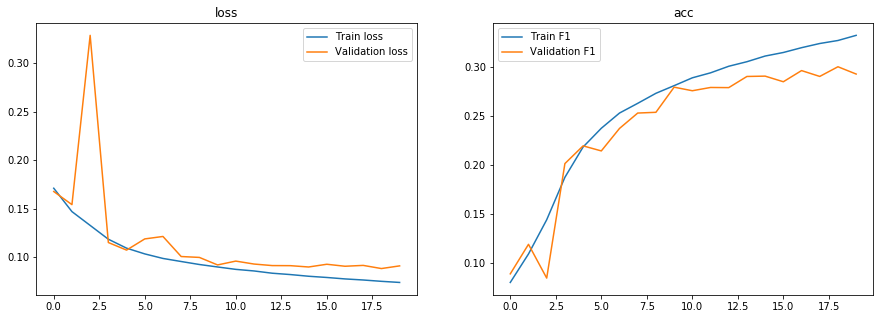

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].set_title('loss')
ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
ax[1].set_title('acc')
ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1") 
ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1")
ax[0].legend()
ax[1].legend()

In [12]:
# fine-tuning

for layer in model.layers:
    layer.trainable = False
    
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True
model.layers[-4].trainable = True
model.layers[-5].trainable = True
model.layers[-6].trainable = True
model.layers[-7].trainable = True

model.compile(loss=f1_loss,
            optimizer=Adam(lr=1e-4),
            metrics=['accuracy', f1])

model.fit_generator(
    tg,
    steps_per_epoch=len(tg),
    validation_data=vg,
    validation_steps=8,
    epochs=1,
    use_multiprocessing=use_multiprocessing, # you have to train the model on GPU in order to this to be benefitial
    workers=workers, # you have to train the model on GPU in order to this to be benefitial
    verbose=1,
    max_queue_size=4
)

Epoch 1/1


151/874 [====>.........................] - ETA: 32:44 - loss: 0.7324 - acc: 0.5938 - f1: 0.267 - ETA: 19:35 - loss: 0.6995 - acc: 0.6250 - f1: 0.300 - ETA: 16:54 - loss: 0.6891 - acc: 0.6562 - f1: 0.310 - ETA: 16:41 - loss: 0.6643 - acc: 0.6797 - f1: 0.335 - ETA: 16:47 - loss: 0.6595 - acc: 0.6625 - f1: 0.340 - ETA: 16:23 - loss: 0.6596 - acc: 0.6615 - f1: 0.340 - ETA: 15:48 - loss: 0.6565 - acc: 0.6384 - f1: 0.343 - ETA: 15:21 - loss: 0.6679 - acc: 0.6602 - f1: 0.332 - ETA: 15:04 - loss: 0.6687 - acc: 0.6806 - f1: 0.331 - ETA: 15:02 - loss: 0.6665 - acc: 0.6844 - f1: 0.333 - ETA: 14:53 - loss: 0.6654 - acc: 0.6705 - f1: 0.334 - ETA: 15:12 - loss: 0.6655 - acc: 0.6693 - f1: 0.334 - ETA: 15:22 - loss: 0.6676 - acc: 0.6659 - f1: 0.332 - ETA: 15:23 - loss: 0.6633 - acc: 0.6540 - f1: 0.336 - ETA: 15:27 - loss: 0.6610 - acc: 0.6562 - f1: 0.339 - ETA: 15:16 - loss: 0.6612 - acc: 0.6562 - f1: 0.338 - ETA: 15:06 - loss: 0.6592 - acc: 0.6507 - f1: 0.340 - ETA: 15:06 - loss: 0.6588 - acc: 0.6441

303/874 [=========>....................] - ETA: 12:27 - loss: 0.6580 - acc: 0.6403 - f1: 0.342 - ETA: 12:25 - loss: 0.6582 - acc: 0.6408 - f1: 0.341 - ETA: 12:24 - loss: 0.6577 - acc: 0.6413 - f1: 0.342 - ETA: 12:23 - loss: 0.6571 - acc: 0.6402 - f1: 0.342 - ETA: 12:21 - loss: 0.6570 - acc: 0.6401 - f1: 0.343 - ETA: 12:20 - loss: 0.6572 - acc: 0.6402 - f1: 0.342 - ETA: 12:19 - loss: 0.6570 - acc: 0.6403 - f1: 0.343 - ETA: 12:17 - loss: 0.6567 - acc: 0.6406 - f1: 0.343 - ETA: 12:16 - loss: 0.6567 - acc: 0.6405 - f1: 0.343 - ETA: 12:15 - loss: 0.6570 - acc: 0.6406 - f1: 0.343 - ETA: 12:13 - loss: 0.6567 - acc: 0.6415 - f1: 0.343 - ETA: 12:11 - loss: 0.6561 - acc: 0.6414 - f1: 0.343 - ETA: 12:10 - loss: 0.6558 - acc: 0.6411 - f1: 0.344 - ETA: 12:09 - loss: 0.6563 - acc: 0.6410 - f1: 0.343 - ETA: 12:07 - loss: 0.6565 - acc: 0.6411 - f1: 0.343 - ETA: 12:06 - loss: 0.6564 - acc: 0.6417 - f1: 0.343 - ETA: 12:05 - loss: 0.6565 - acc: 0.6431 - f1: 0.343 - ETA: 12:04 - loss: 0.6562 - acc: 0.6437

460/874 [==============>...............] - ETA: 9:48 - loss: 0.6476 - acc: 0.6535 - f1: 0.35 - ETA: 9:47 - loss: 0.6473 - acc: 0.6536 - f1: 0.35 - ETA: 9:46 - loss: 0.6474 - acc: 0.6534 - f1: 0.35 - ETA: 9:45 - loss: 0.6473 - acc: 0.6538 - f1: 0.35 - ETA: 9:44 - loss: 0.6474 - acc: 0.6536 - f1: 0.35 - ETA: 9:43 - loss: 0.6471 - acc: 0.6538 - f1: 0.35 - ETA: 9:42 - loss: 0.6471 - acc: 0.6539 - f1: 0.35 - ETA: 9:41 - loss: 0.6468 - acc: 0.6541 - f1: 0.35 - ETA: 9:40 - loss: 0.6467 - acc: 0.6544 - f1: 0.35 - ETA: 9:38 - loss: 0.6469 - acc: 0.6544 - f1: 0.35 - ETA: 9:38 - loss: 0.6467 - acc: 0.6546 - f1: 0.35 - ETA: 9:37 - loss: 0.6466 - acc: 0.6547 - f1: 0.35 - ETA: 9:36 - loss: 0.6465 - acc: 0.6551 - f1: 0.35 - ETA: 9:35 - loss: 0.6465 - acc: 0.6550 - f1: 0.35 - ETA: 9:34 - loss: 0.6464 - acc: 0.6555 - f1: 0.35 - ETA: 9:33 - loss: 0.6464 - acc: 0.6553 - f1: 0.35 - ETA: 9:33 - loss: 0.6466 - acc: 0.6554 - f1: 0.35 - ETA: 9:32 - loss: 0.6464 - acc: 0.6554 - f1: 0.35 - ETA: 9:31 - loss: 0.6

617/874 [====================>.........] - ETA: 7:21 - loss: 0.6418 - acc: 0.6521 - f1: 0.35 - ETA: 7:20 - loss: 0.6418 - acc: 0.6523 - f1: 0.35 - ETA: 7:19 - loss: 0.6418 - acc: 0.6524 - f1: 0.35 - ETA: 7:18 - loss: 0.6416 - acc: 0.6524 - f1: 0.35 - ETA: 7:17 - loss: 0.6417 - acc: 0.6524 - f1: 0.35 - ETA: 7:16 - loss: 0.6415 - acc: 0.6525 - f1: 0.35 - ETA: 7:15 - loss: 0.6415 - acc: 0.6527 - f1: 0.35 - ETA: 7:14 - loss: 0.6415 - acc: 0.6525 - f1: 0.35 - ETA: 7:13 - loss: 0.6416 - acc: 0.6524 - f1: 0.35 - ETA: 7:12 - loss: 0.6416 - acc: 0.6523 - f1: 0.35 - ETA: 7:11 - loss: 0.6415 - acc: 0.6524 - f1: 0.35 - ETA: 7:10 - loss: 0.6416 - acc: 0.6524 - f1: 0.35 - ETA: 7:09 - loss: 0.6417 - acc: 0.6520 - f1: 0.35 - ETA: 7:08 - loss: 0.6416 - acc: 0.6520 - f1: 0.35 - ETA: 7:07 - loss: 0.6416 - acc: 0.6520 - f1: 0.35 - ETA: 7:06 - loss: 0.6416 - acc: 0.6518 - f1: 0.35 - ETA: 7:05 - loss: 0.6415 - acc: 0.6518 - f1: 0.35 - ETA: 7:04 - loss: 0.6416 - acc: 0.6516 - f1: 0.35 - ETA: 7:03 - loss: 0.6

774/874 [=========================>....] - ETA: 4:41 - loss: 0.6355 - acc: 0.6518 - f1: 0.36 - ETA: 4:40 - loss: 0.6354 - acc: 0.6518 - f1: 0.36 - ETA: 4:39 - loss: 0.6354 - acc: 0.6518 - f1: 0.36 - ETA: 4:38 - loss: 0.6354 - acc: 0.6516 - f1: 0.36 - ETA: 4:37 - loss: 0.6354 - acc: 0.6516 - f1: 0.36 - ETA: 4:36 - loss: 0.6355 - acc: 0.6515 - f1: 0.36 - ETA: 4:35 - loss: 0.6354 - acc: 0.6516 - f1: 0.36 - ETA: 4:34 - loss: 0.6353 - acc: 0.6516 - f1: 0.36 - ETA: 4:33 - loss: 0.6353 - acc: 0.6516 - f1: 0.36 - ETA: 4:32 - loss: 0.6353 - acc: 0.6516 - f1: 0.36 - ETA: 4:31 - loss: 0.6352 - acc: 0.6517 - f1: 0.36 - ETA: 4:30 - loss: 0.6353 - acc: 0.6516 - f1: 0.36 - ETA: 4:29 - loss: 0.6353 - acc: 0.6516 - f1: 0.36 - ETA: 4:28 - loss: 0.6352 - acc: 0.6515 - f1: 0.36 - ETA: 4:26 - loss: 0.6352 - acc: 0.6515 - f1: 0.36 - ETA: 4:25 - loss: 0.6352 - acc: 0.6516 - f1: 0.36 - ETA: 4:24 - loss: 0.6352 - acc: 0.6518 - f1: 0.36 - ETA: 4:23 - loss: 0.6352 - acc: 0.6518 - f1: 0.36 - ETA: 4:22 - loss: 0.6

874/874 [==============================] - ETA: 1:59 - loss: 0.6319 - acc: 0.6505 - f1: 0.36 - ETA: 1:58 - loss: 0.6320 - acc: 0.6504 - f1: 0.36 - ETA: 1:57 - loss: 0.6320 - acc: 0.6503 - f1: 0.36 - ETA: 1:56 - loss: 0.6320 - acc: 0.6503 - f1: 0.36 - ETA: 1:54 - loss: 0.6318 - acc: 0.6504 - f1: 0.36 - ETA: 1:53 - loss: 0.6318 - acc: 0.6506 - f1: 0.36 - ETA: 1:52 - loss: 0.6318 - acc: 0.6504 - f1: 0.36 - ETA: 1:51 - loss: 0.6317 - acc: 0.6503 - f1: 0.36 - ETA: 1:50 - loss: 0.6317 - acc: 0.6501 - f1: 0.36 - ETA: 1:49 - loss: 0.6316 - acc: 0.6500 - f1: 0.36 - ETA: 1:48 - loss: 0.6316 - acc: 0.6501 - f1: 0.36 - ETA: 1:46 - loss: 0.6315 - acc: 0.6501 - f1: 0.36 - ETA: 1:45 - loss: 0.6315 - acc: 0.6502 - f1: 0.36 - ETA: 1:44 - loss: 0.6315 - acc: 0.6502 - f1: 0.36 - ETA: 1:43 - loss: 0.6314 - acc: 0.6502 - f1: 0.36 - ETA: 1:42 - loss: 0.6314 - acc: 0.6504 - f1: 0.36 - ETA: 1:41 - loss: 0.6314 - acc: 0.6504 - f1: 0.36 - ETA: 1:40 - loss: 0.6314 - acc: 0.6502 - f1: 0.36 - ETA: 1:38 - loss: 0.6

# Full validation
Perform validation on full validation dataset. Choose appropriate prediction threshold maximalizing the validation F1-score.

In [13]:
bestModel = load_model('./base.model', custom_objects={'f1': f1}) #, 'f1_loss': f1_loss})
#bestModel = model

In [14]:
fullValGen = vg

In [15]:
from sklearn.metrics import f1_score as off1

def getOptimalT(mdl, fullValGen):
    
    lastFullValPred = np.empty((0, 28))
    lastFullValLabels = np.empty((0, 28))
    for i in tqdm(range(len(fullValGen))): 
        im, lbl = fullValGen[i]
        scores = mdl.predict(im)
        lastFullValPred = np.append(lastFullValPred, scores, axis=0)
        lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    print(lastFullValPred.shape, lastFullValLabels.shape)
    
    rng = np.arange(0, 1, 0.001)
    f1s = np.zeros((rng.shape[0], 28))
    for j,t in enumerate(tqdm(rng)):
        for i in range(28):
            p = np.array(lastFullValPred[:,i]>t, dtype=np.int8)
            #scoref1 = K.eval(f1_score(fullValLabels[:,i], p, average='binary'))
            scoref1 = off1(lastFullValLabels[:,i], p, average='binary')
            f1s[j,i] = scoref1
            
    print(np.max(f1s, axis=0))
    print(np.mean(np.max(f1s, axis=0)))
    
    plt.plot(rng, f1s)
    T = np.empty(28)
    for i in range(28):
        T[i] = rng[np.where(f1s[:,i] == np.max(f1s[:,i]))[0][0]]
    #print('Choosing threshold: ', T, ', validation F1-score: ', max(f1s))
    print(T)
    
    return T, np.mean(np.max(f1s, axis=0))

Last model after fine-tuning


100%|██████████| 98/98 [02:33<00:00,  1.13s/it]


(3108, 28) (3108, 28)


  0%|          | 0/1000 [00:00<?, ?it/s]C:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
 34%|███▍      | 344/1000 [00:09<00:17, 37.18it/s]C:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 1000/1000 [00:27<00:00, 37.58it/s]


[0.82949982 0.86363636 0.79765396 0.75884244 0.77211796 0.7016129
 0.57333333 0.77094972 0.8        0.57142857 0.8        0.70204082
 0.56578947 0.56338028 0.85024155 0.02       0.38709677 0.51612903
 0.53012048 0.63013699 0.54545455 0.65871122 0.57608696 0.82747069
 0.81481481 0.68477646 0.45070423 0.        ]
0.6272153346617294
[0.318 0.235 0.288 0.438 0.186 0.735 0.223 0.285 0.132 0.558 0.723 0.123
 0.651 0.999 0.141 0.001 0.337 0.437 0.681 0.748 0.994 0.482 0.772 0.48
 0.933 0.554 0.837 0.   ]


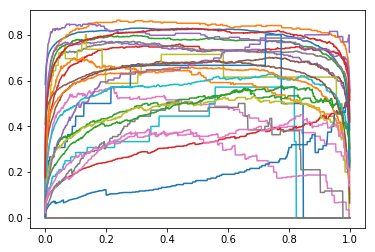

In [16]:
fullValGen = ProteinDataGenerator(paths[lastTrainIndex:], labels[lastTrainIndex:], BATCH_SIZE, SHAPE)
print('Last model after fine-tuning')
T1, ff1 = getOptimalT(model, fullValGen)

Best save model


100%|██████████| 98/98 [02:25<00:00,  1.12s/it]


(3108, 28) (3108, 28)


  0%|          | 0/1000 [00:00<?, ?it/s]C:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
 17%|█▋        | 171/1000 [00:04<00:23, 35.20it/s]C:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████| 1000/1000 [00:26<00:00, 37.23it/s]


[0.83437846 0.82868526 0.80055788 0.74538745 0.80327869 0.70515464
 0.5375     0.76029963 0.82352941 0.44444444 0.66666667 0.66968326
 0.54237288 0.53731343 0.85067873 0.02739726 0.35897436 0.53846154
 0.51034483 0.6031746  0.4        0.65587918 0.56953642 0.82393162
 0.84       0.68146504 0.45783133 0.        ]
0.6077473933126832
[0.28  0.148 0.406 0.337 0.675 0.269 0.156 0.604 0.227 0.12  0.247 0.161
 0.444 0.676 0.441 0.009 0.291 0.231 0.529 0.283 0.793 0.417 0.371 0.481
 0.953 0.325 0.208 0.   ]


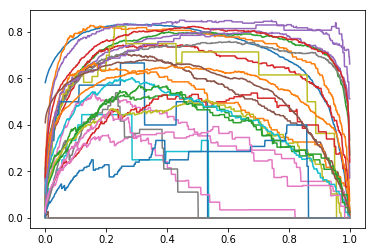

In [17]:
print('Best save model')
T2, ff2 = getOptimalT(bestModel, fullValGen)

In [18]:
if ff1 > ff2:
    T = T1
    bestModel = model
else:
    T = T2
    bestModel = bestModel

In [19]:
pathsTest, labelsTest = getTestDataset()

testg = ProteinDataGenerator(pathsTest, labelsTest, BATCH_SIZE, SHAPE)
submit = pd.read_csv(DIR + '/sample_submission.csv')
P = np.zeros((pathsTest.shape[0], 28))
for i in tqdm(range(len(testg))):
    images, labels = testg[i]
    score = bestModel.predict(images)
    P[i*BATCH_SIZE:i*BATCH_SIZE+score.shape[0]] = score

100%|██████████| 366/366 [12:49<00:00,  1.85s/it]


In [20]:
PP = np.array(P)

In [21]:
prediction = []

for row in tqdm(range(submit.shape[0])):
    
    str_label = ''
    
    for col in range(PP.shape[1]):
        if(PP[row, col] < T[col]):
            str_label += ''
        else:
            str_label += str(col) + ' '
    prediction.append(str_label.strip())
    
submit['Predicted'] = np.array(prediction)
submit.to_csv('4channels_cnn_from_scratch.csv', index=False)

100%|██████████| 11702/11702 [00:00<00:00, 77534.02it/s]
